# CA2 Part 1 (Time Series Forecasting)

Done By: Darius Khoo  
  

Admin Number: 2222259  
  

Class: DAAA/FT/2A/06  
  

---

### **Background**
Using the Energy Consumption Dataset to train time series models and forecast
the gas consumption, electricity consumption and water consumption in the
future.

### **Task** 
- Write the code to solve the time series prediction. For the time series model,use Statsmodels only (do not use other 3rd party libraries such as autoML).

- Tune the hyperparameters of the time series model to maximize the accuracy for training data and testing data prediction.

- Write a short report detailing your implementation, your experiments and analysis in the Jupyter notebook (along with your python code and comments).

- Create a set of slides with the highlights of your Jupyter notebook. Explain the time series prediction process, model building and evaluation. Write your conclusions.

In [ ]:
pip install prophet

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import datetime
from dateutil.relativedelta import relativedelta



# Statistical Analysis
# Statistical Tests, Plots, and Visualizations
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, coint
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pipelines
from sklearn.pipeline import Pipeline

# Forecasting
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

# Hyperparameter Tuning
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import make_scorer
sns.set()

from warnings import filterwarnings 
filterwarnings('ignore')
rng = np.random.RandomState(42)

df = pd.read_csv('./data/Energy Consumption Dataset.csv')

o P-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.  


o P-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [139]:
df.head(8)

,DATE,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
0,1/1/1990,18.0,725.1,548.8
1,1/2/1990,15.8,706.7,640.7
2,1/3/1990,17.3,624.5,511.1
3,1/4/1990,18.9,574.7,515.3
4,1/5/1990,22.0,553.2,488.4
5,1/6/1990,23.4,580.9,503.2
6,1/7/1990,24.6,626.2,448.3
7,1/8/1990,24.8,632.5,411.7


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           397 non-null    object 
 1   Gas Consumption (tons)         397 non-null    float64
 2   Electricity Consumption (MWh)  397 non-null    float64
 3   Water Consumption (tons)       397 non-null    float64
dtypes: float64(3), object(1)
memory usage: 12.5+ KB


In [141]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gas Consumption (tons),397.0,23.785139,4.903452,11.6,20.2,23.5,27.9,46.0
Electricity Consumption (MWh),397.0,888.472544,153.877594,553.2,771.1,897.8,1005.2,1294.0
Water Consumption (tons),397.0,484.953652,133.908863,44.4,384.4,487.4,580.2,811.0


we can immediately see outlier in the water consumption data

In [311]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y")

display(df.dtypes)

df.set_index("DATE", inplace=True)

DATE                             datetime64[ns]
Gas Consumption (tons)                  float64
Electricity Consumption (MWh)           float64
Water Consumption (tons)                float64
dtype: object

> I set the Date column as a datetime dtype and made it my index 

In [143]:
print(f'the dates are from {df.index.min()} to {df.index.max()}')
print(f'{df.index[0]}, {df.index[1]}')

the dates are from 1990-01-01 00:00:00 to 2023-01-01 00:00:00
1990-01-01 00:00:00, 1990-02-01 00:00:00


> The range of dates and we can see what each date represents

---

## Univariate Analysis

In [144]:
# sns.displot(x='Gas Consumption (tons)', kde=True, height=8, data=df)
# plt.title('Distribution of Gas Consumption (tons)')
# plt.show()

In [145]:
# sns.displot(x='Electricity Consumption (MWh)', kde=True, height=8, data=df, color = 'black')
# plt.title('Distribution of Gas Consumption (tons)')
# plt.show()

In [146]:
# sns.displot(x='Gas Consumption (tons)', kde=True, height=8, data=df, color = 'orange')
# plt.title('Water Consumption (tons)')
# plt.show()

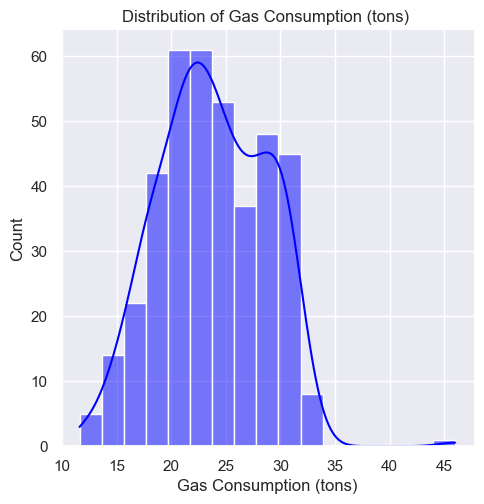

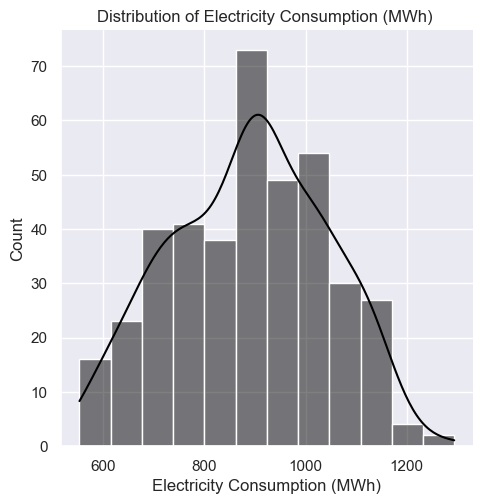

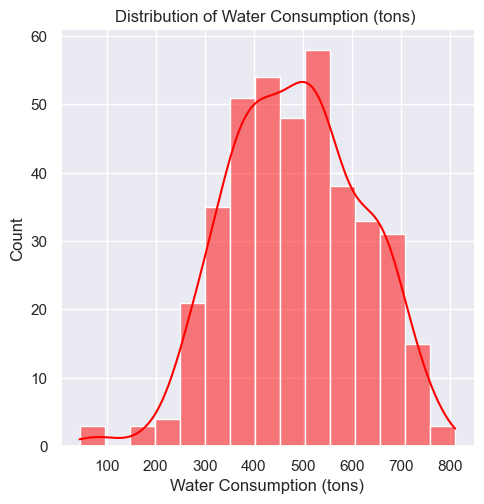

In [147]:
x_values = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']
colors = ['blue', 'black', 'red']

for x, color in zip(x_values, colors):
    sns.displot(x=x, kde=True, height=5, data=df, color=color)
    plt.title(f"Distribution of {x} ")
    plt.show()

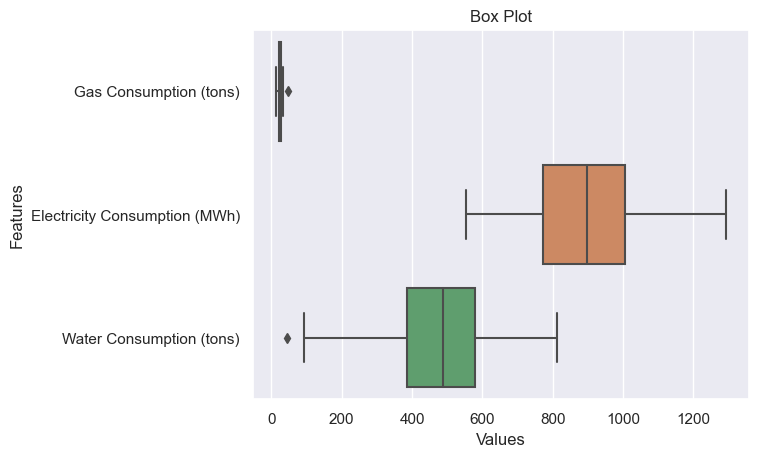

In [148]:
sns.boxplot(data=df , orient= 'h')

# Set labels and title
plt.xlabel("Values")
plt.ylabel("Features")
plt.title("Box Plot")

# Show the plot
plt.show()

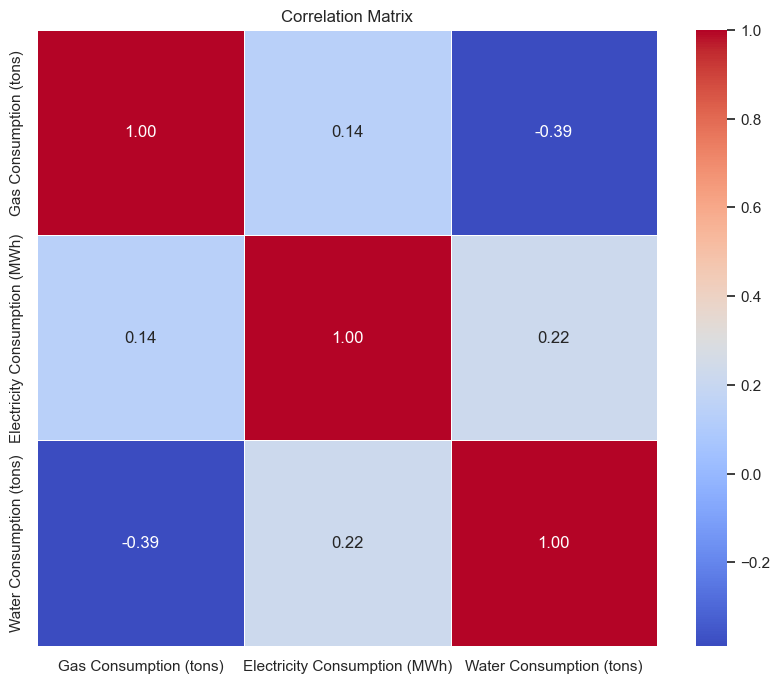

In [149]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

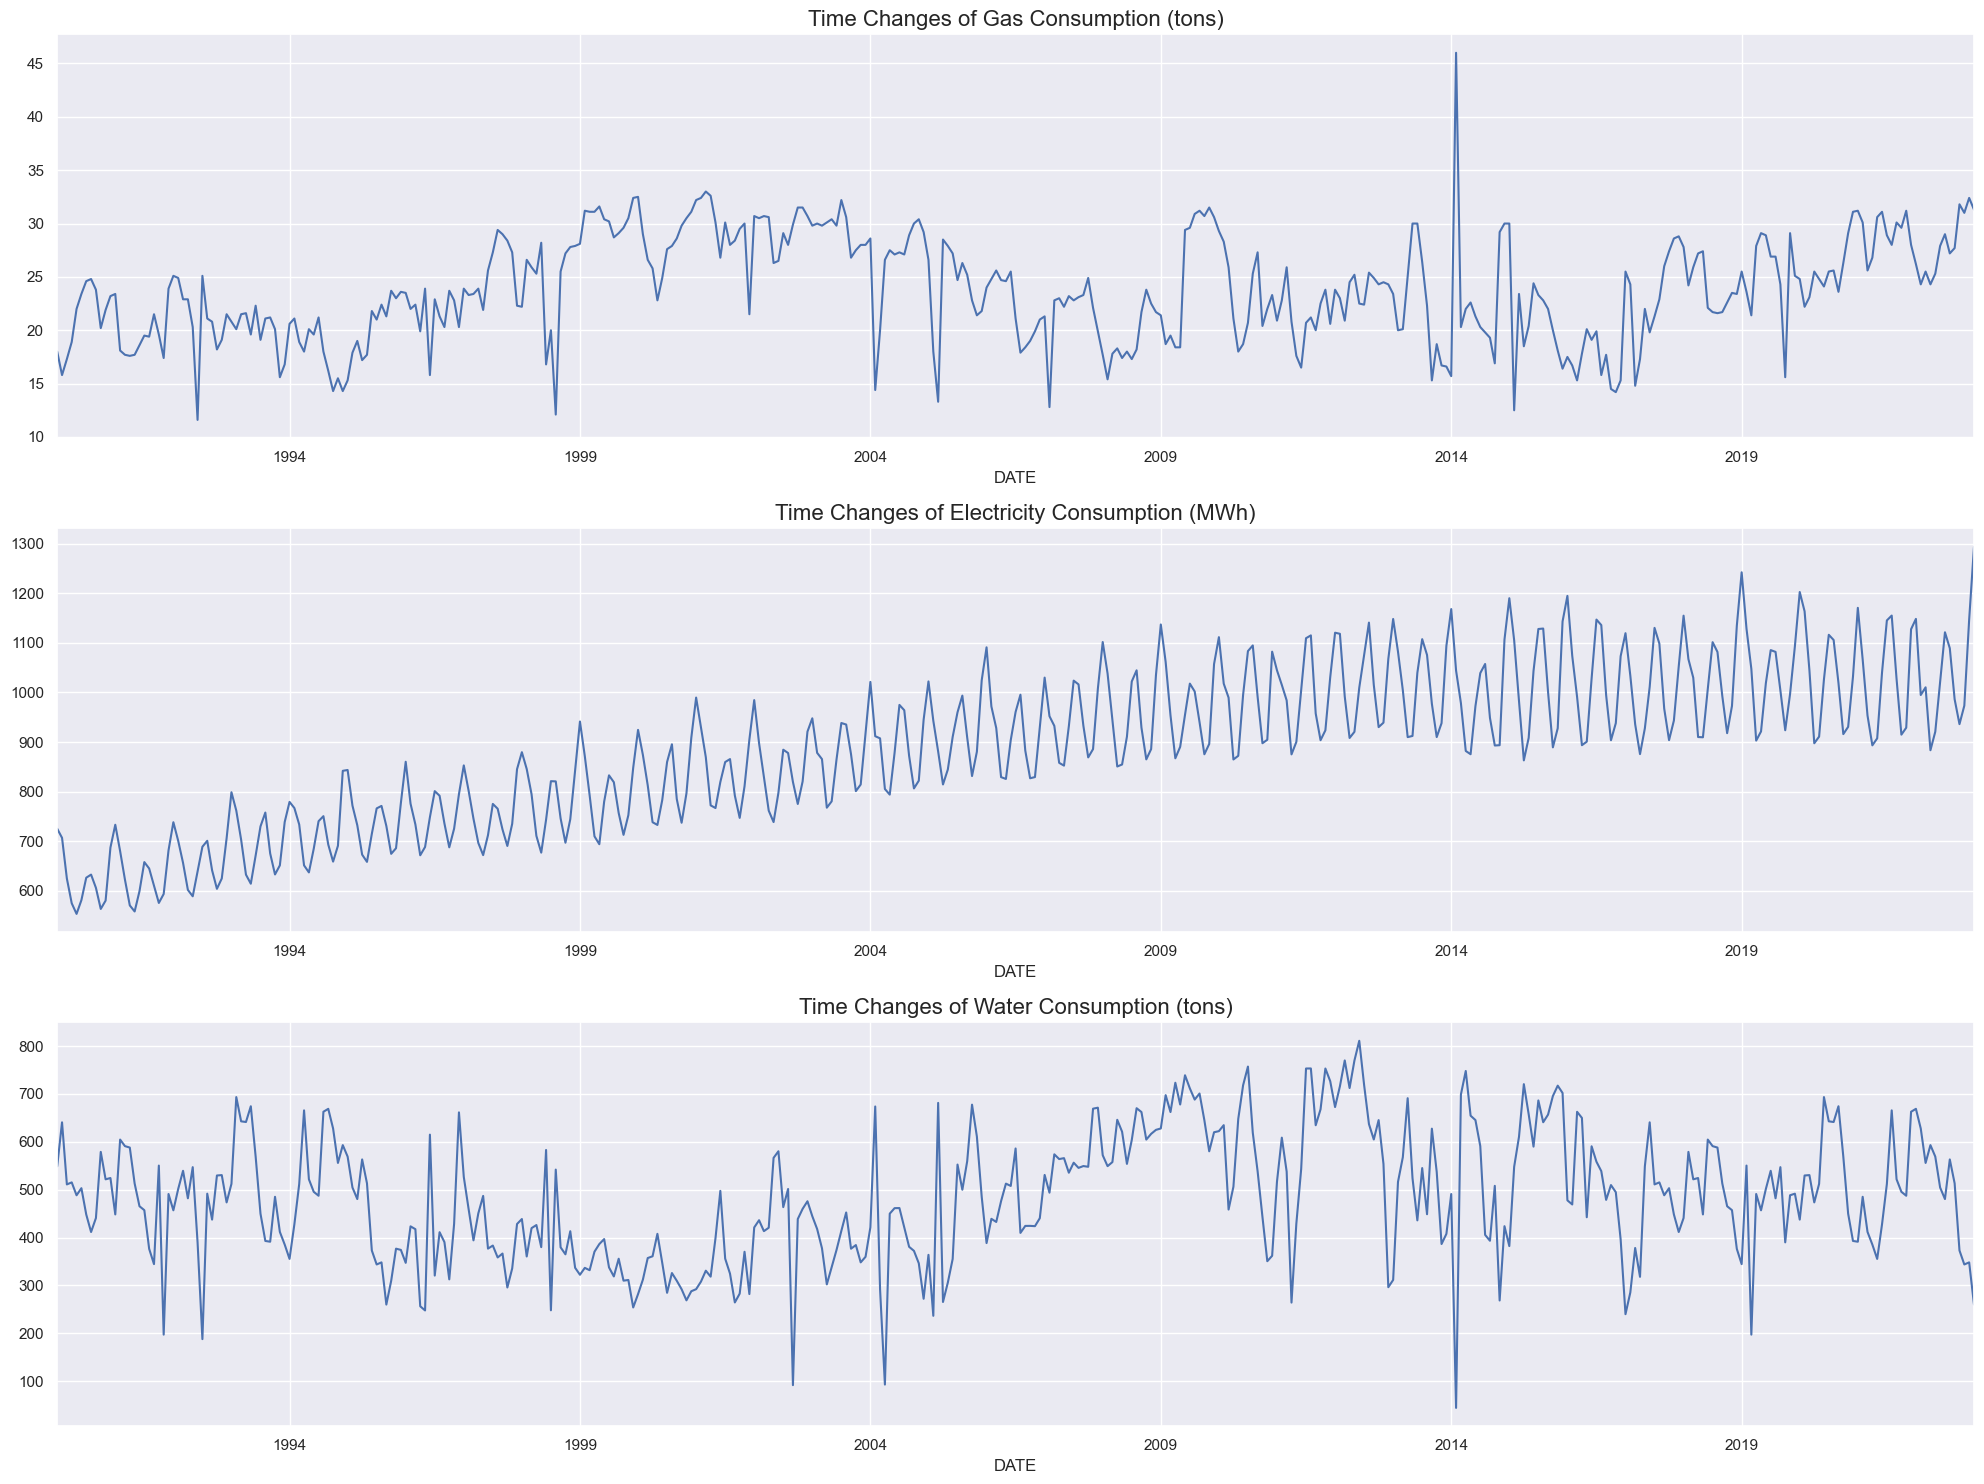

In [150]:
continuous = ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']
fig = plt.figure(tight_layout=True, figsize=(20, 15))
for i, column in enumerate(continuous):
    ax = fig.add_subplot(len(continuous), 1, i + 1)
    df[column].plot(ax=ax)
    ax.set_title("Time Changes of " + column, fontsize=16)
plt.show()

## Time Series Decomposition

Before we do anything we need to perform a few test to check the dataset, that includes
<!-- 
- Autocorrelation Test
- Stationarity Test
- Seasonality Test
- Unit Root Test
- Granger Causality Test
- Residual Analysis -->
- Test for Trends
- Test for Stationarity 
- Residual Analysis
- Outlier Analysis 

First lets start with the most basic test which is test for stationarity, many models such as ARIMA requires the data to be stationary to carry out forecasting, hence we need to check the each feature for stationarity, if it happens to not stationary we need to change that later on

Lets use the Dicky Fuller Test to evaluate

In [151]:
# adftest = adfuller(df['Gas Consumption (tons)'])
# signifcance_level = 0.05
# print('Number of observations:', adftest[3])
# print()
# print(signifcance_level)
# print('p-value', adftest[1])



# print()
# for key, value in adftest[4].items():
#     # print("Significance Level:", key)
#     print(f"Critical Value at {key}:", value)
    
# print()    

# print('Test Statistic Value:', adftest[0])


# print()
# if adftest[1] < signifcance_level:
#     print('Reject Null Hypothesis')
#     print('The data is Stationary')
# else:
#     print('Accept Null Hypothesis')
#     print('The data is Non-Stationary')

In [152]:
def evaluate_stationarity(data, columns, significance_level=0.05):
    for column in columns:
        adftest = adfuller(data[column])
        
        print("Column:", column)
        print("Number of observations:", adftest[3])
        print()
        print("Significance Level:", significance_level)
        print("p-value:", adftest[1])


        print()

        for key, value in adftest[4].items():
            print(f"Critical Value at {key}:", value)
        print()
        print('Test Statistic Value:', adftest[0])
        print()
        if adftest[1] < significance_level:
            print('Since p-value < significance level we reject the Null Hypothesis')
            print('The data is Stationary')
        elif adftest[1] > significance_level:
            print('Since p-value > significance level we Accept the Null Hypothesis')
            print('The data is Non-Stationary')

        print('-' * 50)
        print()


columns =  ['Gas Consumption (tons)', 'Electricity Consumption (MWh)', 'Water Consumption (tons)']  # Specify the columns to evaluate

evaluate_stationarity(df, columns)


Column: Gas Consumption (tons)
Number of observations: 390

Significance Level: 0.05
p-value: 0.01081065170706051

Critical Value at 1%: -3.4472291365835566
Critical Value at 5%: -2.8689795375849223
Critical Value at 10%: -2.5707330834976987

Test Statistic Value: -3.4043743333182728

Since p-value < significance level we reject the Null Hypothesis
The data is Stationary
--------------------------------------------------

Column: Electricity Consumption (MWh)
Number of observations: 381

Significance Level: 0.05
p-value: 0.18621802300336632

Critical Value at 1%: -3.4476305904172904
Critical Value at 5%: -2.869155980820355
Critical Value at 10%: -2.570827146203181

Test Statistic Value: -2.256980549592542

Since p-value > significance level we Accept the Null Hypothesis
The data is Non-Stationary
--------------------------------------------------

Column: Water Consumption (tons)
Number of observations: 392

Significance Level: 0.05
p-value: 8.984549388336973e-05

Critical Value at 1%:

In [153]:
# Perform KPSS test
result = kpss(df['Gas Consumption (tons)'])

# Extract test statistics and p-value
test_statistic = result[0]
p_value = result[1]
critical_values = result[3]

# Print the results
print(f"KPSS Test Statistic: {test_statistic}")
print(f"p-value: {p_value}")
print("Critical values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")

# Interpret the results
if p_value < 0.05:
    print("The series is not stationary (reject the null hypothesis)")
else:
    print("The series is stationary (fail to reject the null hypothesis)")

KPSS Test Statistic: 0.3402153835554435
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)


In [154]:
def kpss_test(data):
    # Iterate over the columns of the data
    for column in data.columns:
        # Perform KPSS test
        result = kpss(data[column])

        # Extract test statistics and p-value
        test_statistic = result[0]
        p_value = result[1]
        critical_values = result[3]

        # Print the results
        print(f"Column: {column}")
        print(f"KPSS Test Statistic: {test_statistic}")
        print(f"p-value: {p_value}")
        print("Critical values:")
        for key, value in critical_values.items():
            print(f"  {key}: {value}")

        # Interpret the results
        if p_value < 0.05:
            print("The series is not stationary (reject the null hypothesis)")
        else:
            print("The series is stationary (fail to reject the null hypothesis)")
        print()

In [155]:
kpss_test(df)


Column: Gas Consumption (tons)
KPSS Test Statistic: 0.3402153835554435
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)

Column: Electricity Consumption (MWh)
KPSS Test Statistic: 3.531601452001429
p-value: 0.01
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is not stationary (reject the null hypothesis)

Column: Water Consumption (tons)
KPSS Test Statistic: 0.8388411776971113
p-value: 0.01
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is not stationary (reject the null hypothesis)



In [156]:
df1 = pd.DataFrame()

df1['Differenced_water'] = df['Water Consumption (tons)'].diff().dropna()
df1['Differenced_electricity'] = df['Electricity Consumption (MWh)'].diff().dropna()
kpss_test(df1)

Column: Differenced_water
KPSS Test Statistic: 0.11112601659149662
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)

Column: Differenced_electricity
KPSS Test Statistic: 0.14519067668792815
p-value: 0.1
Critical values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject the null hypothesis)



In [157]:
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')
# pd.reset_option('display.width')
df

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


## *Seasonality Decomposition*

In [158]:
decompose = seasonal_decompose(df['Gas Consumption (tons)'])


trend = decompose.trend
seasonality = decompose.seasonal
residual = decompose.resid

# fig, axs = plt.subplots(4, 1, figsize=(10, 12))
# axs[0].plot(df['Gas Consumption (tons)'])
# axs[0].set_title('Original Time Series')

# axs[1].plot(trend)
# axs[1].set_title('Trend Component')

# axs[2].plot(seasonality)
# axs[2].set_title('Seasonality Component')

# axs[3].plot(residual)
# axs[3].set_title('Residual Component')


# plt.tight_layout()

# print(seasonality.head(15))

# decompose.plot()

# plt.show()





In [159]:
def plot_decomposition(data, column):
    decompose = seasonal_decompose(data[column])

    trend = decompose.trend
    seasonality = decompose.seasonal
    residual = decompose.resid

    print(f'the amount of datapoints per seasons is {len(seasonality.unique())}')
    
    fig, axs = plt.subplots(4, 1, figsize=(15, 12))
    axs[0].plot(data[column])
    axs[0].set_title('Original Time Series')

    axs[1].plot(trend)
    axs[1].set_title('Trend Component')

    axs[2].plot(seasonality)
    axs[2].set_title('Seasonality Component')

    # axs[3].plot(residual)
    # axs[3].set_title('Residual Component'

    axs[3].scatter(range(len(residual)), residual)
    axs[3].axhline(0, color='black', linestyle='--')  
    axs[3].set_title('Residual Component')

    plt.tight_layout()
    plt.show()


the amount of datapoints per seasons is 12


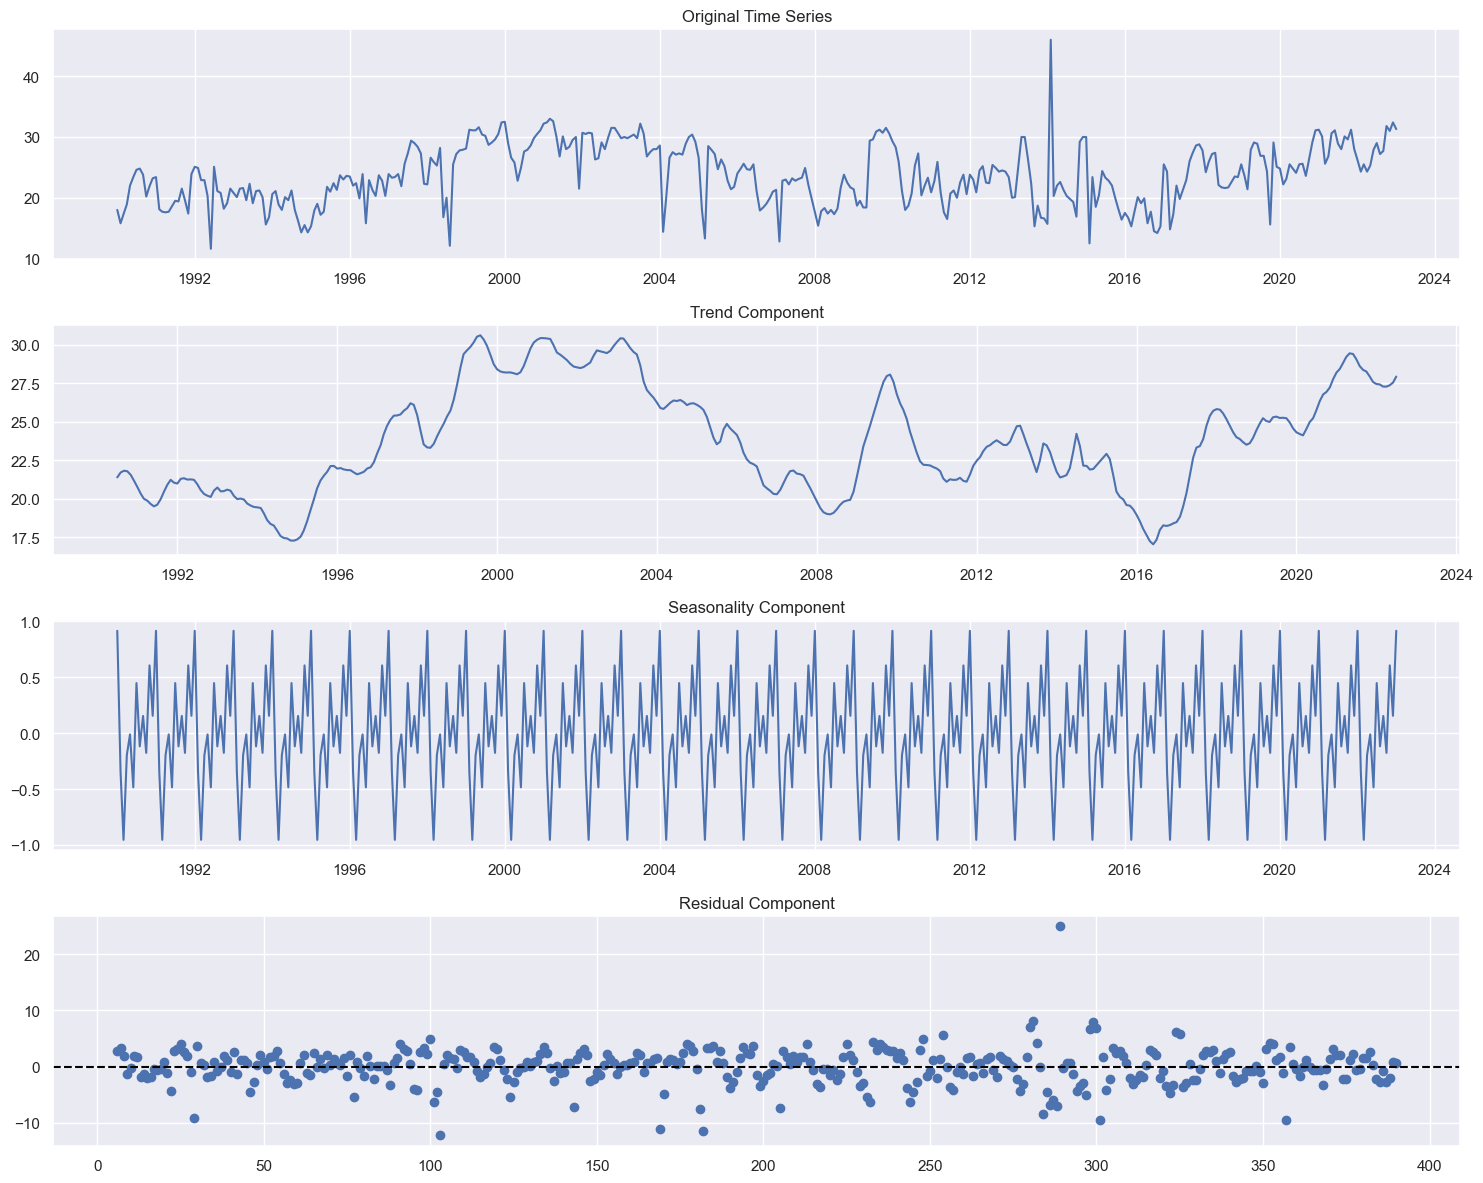

In [160]:
plot_decomposition(df, 'Gas Consumption (tons)')


the amount of datapoints per seasons is 12


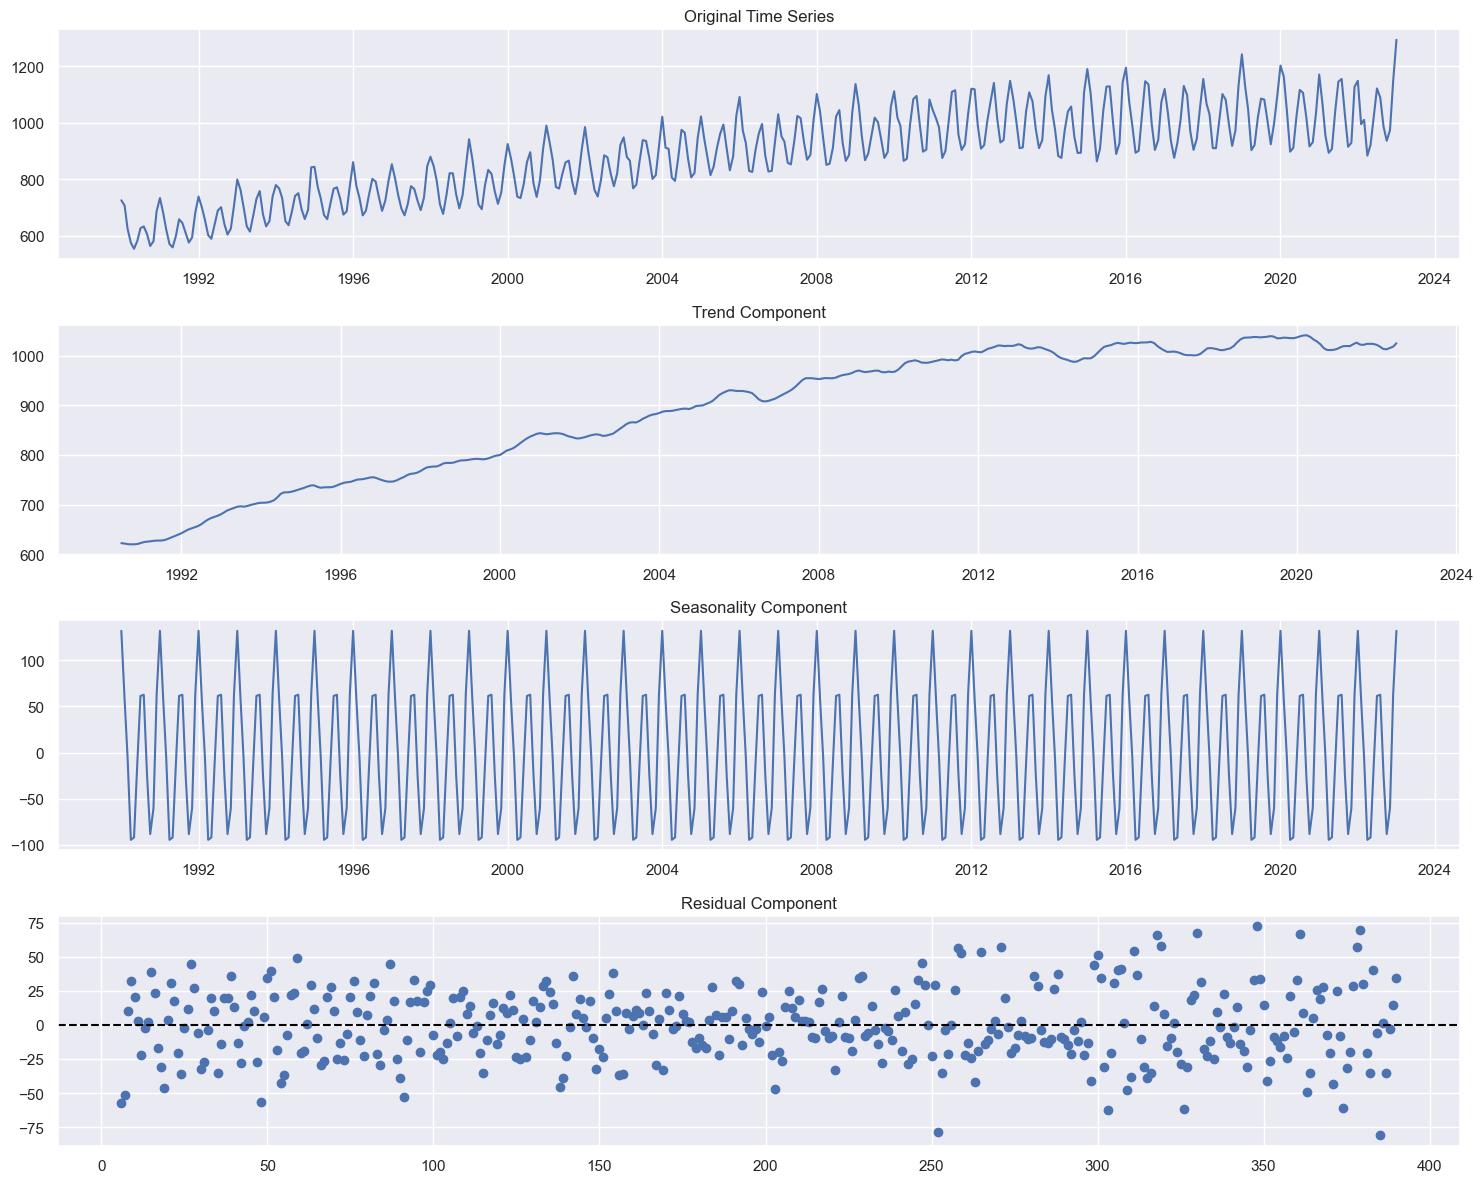

In [161]:
plot_decomposition(df, 'Electricity Consumption (MWh)')


the amount of datapoints per seasons is 12


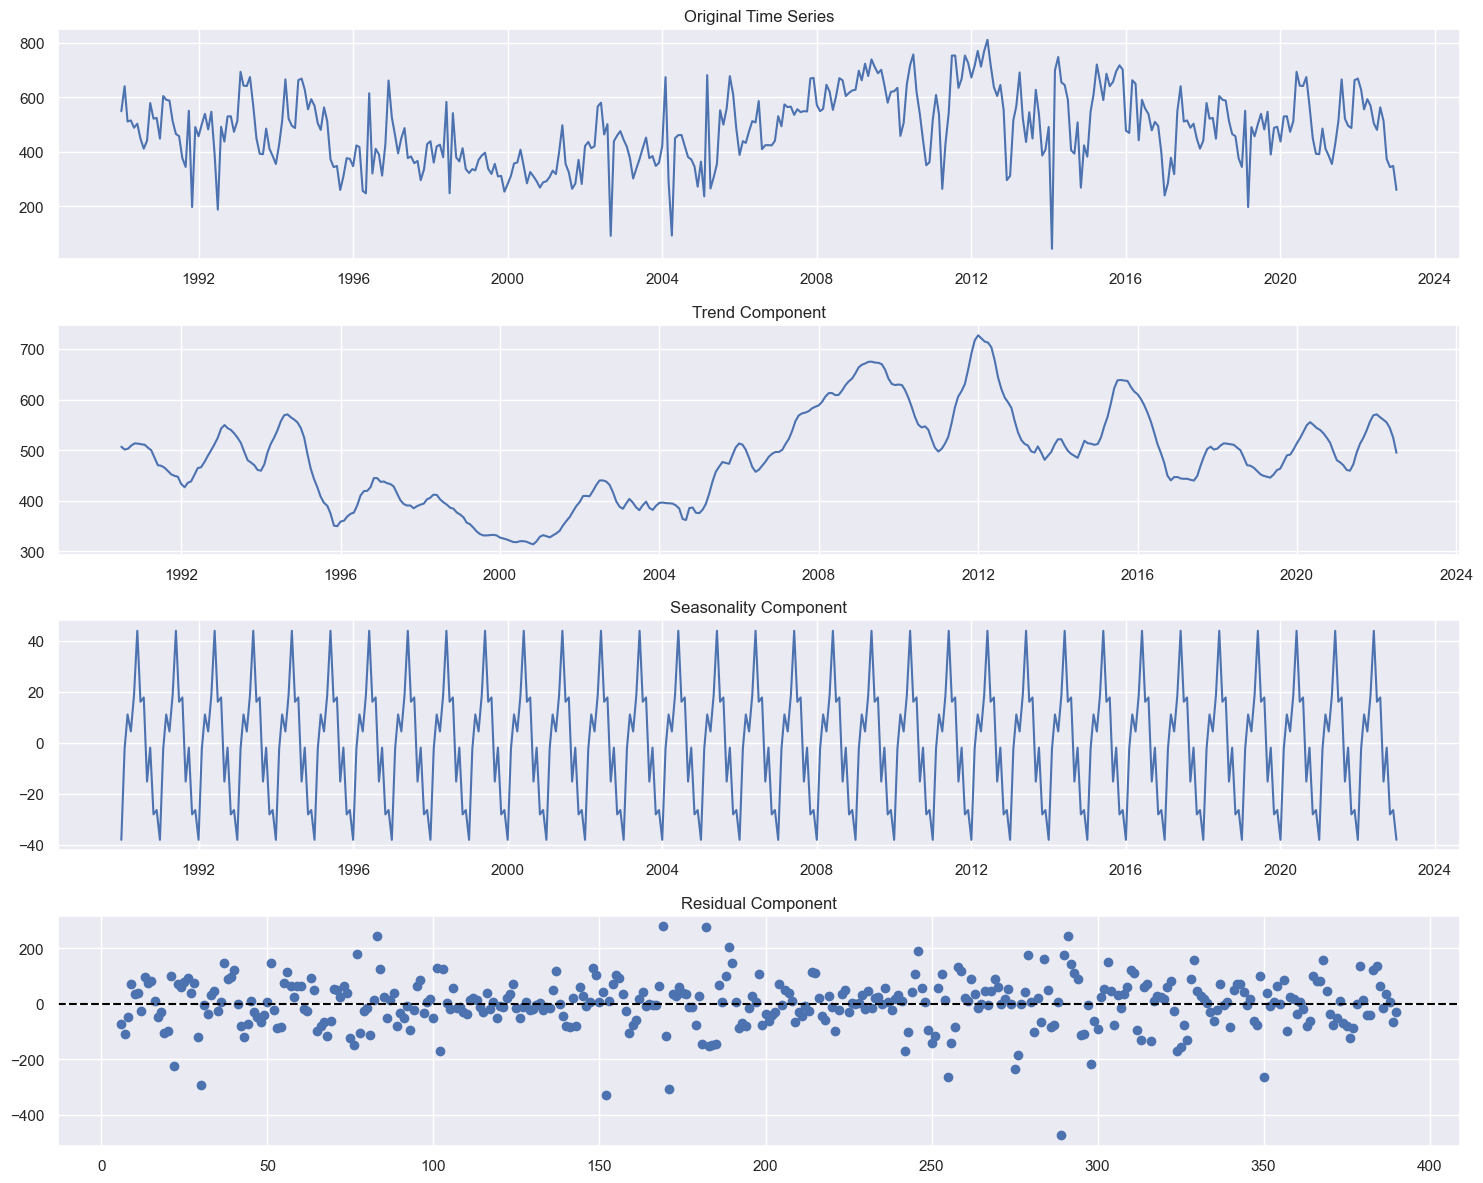

In [162]:
plot_decomposition(df, 'Water Consumption (tons)')


#### **Analysis of all the decompositions**


There are a few points we can extract from this decomposition

- 

---


## *Test for cointegration*

In [163]:
import statsmodels.api as sm

# Assume you have two time series variables, x and y

# Fit a regression model
regression_model = sm.OLS(df['Gas Consumption (tons)'], sm.add_constant(df[('Water Consumption (tons)')])).fit()

# Calculate the residuals
residuals = regression_model.resid

# Perform ADF test on residuals
adf_test = sm.tsa.stattools.adfuller(residuals)

# Extract the p-value from the ADF test result
p_value = adf_test[1]

# Check for cointegration based on the p-value
if p_value < 0.05:
    print("Cointegration exists.")
else:
    print("No cointegration.")

Cointegration exists.


In [164]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assume you have a matrix of multiple time series variables, data

# Perform Johansen cointegration test
result = coint_johansen(df, det_order=0, k_ar_diff=12)

# Extract the eigenvalues and trace statistic
eigenvalues = result.eig
trace_statistic = result.lr1

# Determine the number of cointegrating relationships based on trace statistic
significance_level = 0.05  # Set your desired significance level
num_cointegrating = np.sum(trace_statistic > significance_level)

print("Number of cointegrating relationships:", num_cointegrating)

Number of cointegrating relationships: 3


In [165]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assume you have a matrix of multiple time series variables, data

# Perform Johansen cointegration test
result = coint_johansen(df1, det_order=0, k_ar_diff=12)

# Extract the eigenvalues and trace statistic
eigenvalues = result.eig
trace_statistic = result.lr1

# Determine the number of cointegrating relationships based on trace statistic
significance_level = 0.05  # Set your desired significance level
# num_cointegrating = np.sum(trace_statistic < significance_level)

# print("Number of cointegrating relationships:", num_cointegrating)
significant_p_values = trace_statistic < significance_level


if any(significant_p_values):
    print("There is evidence of cointegration among the variables.")
    for i, p_value in enumerate(p_values):
        if p_value < significance_level:
            print(f"Variable {i+1}: p-value = {p_value:.4f} (significant)")
        else:
            print(f"Variable {i+1}: p-value = {p_value:.4f}")
else:
    print("There is no evidence of cointegration among the variables.")

There is no evidence of cointegration among the variables.


In [166]:
    # import statsmodels.api as sm

    # # Assuming your DataFrame is named df
    # columns = df.columns

    # # Iterate over the columns
    # for i in range(len(columns)):
    #     for j in range(i+1, len(columns)):
    #         x = df[columns[i]]
    #         y = df[columns[j]]

    #         # Fit a regression model
    #         regression_model = sm.OLS(y, sm.add_constant(x)).fit()

    #         # Calculate the residuals
    #         residuals = regression_model.resid

    #         # Perform ADF test on residuals
    #         adf_test = sm.tsa.stattools.adfuller(residuals)

    #         # Extract the p-value from the ADF test result
    #         p_value = adf_test[1]

    #         # Check for cointegration based on the p-value
    #         if p_value < 0.05:
    #             print(f"Cointegration exists between {columns[i]} and {columns[j]}.")
    #         else:
    #             print(f"No cointegration between {columns[i]} and {columns[j]}.")

In [167]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Assume you have a matrix of multiple time series variables, data
# Assuming your DataFrame is named df

# Perform Johansen cointegration test
result = coint_johansen(df, det_order=1, k_ar_diff=12)

# Extract the eigenvalues and trace statistic
eigenvalues = result.eig
trace_statistic = result.lr1

# Determine the number of cointegrating relationships based on trace statistic
significance_level = 0.05  # Set your desired significance level
num_cointegrating = np.sum(trace_statistic > significance_level)

print("Number of cointegrating relationships:", num_cointegrating)

# Get the column names
columns = df.columns

# Iterate over the cointegrating relationships
for i in range(num_cointegrating):
    indices = result.ind[i]
    # Get the column names
    coint_cols =  columns[i]
    print(f"Cointegrating {i+1}: {coint_cols}")

Number of cointegrating relationships: 3
Cointegrating 1: Gas Consumption (tons)
Cointegrating 2: Electricity Consumption (MWh)
Cointegrating 3: Water Consumption (tons)


## *Test for Causation*

In [168]:
lag_order = 2  
max_lag = lag_order + 1 
test_results = grangercausalitytests(df[['Gas Consumption (tons)', 'Water Consumption (tons)']], maxlag=max_lag, verbose=False)

# Extract the p-values from the test results
p_values = [test_results[i+1][0]['ssr_chi2test'][1] for i in range(lag_order)]

# Print the p-values 
for i, p_value in enumerate(p_values):
    lag = i + 1
    print(f"Lag {lag}: p-value = {p_value}")
    if p_value < 0.05:
        print("There is evidence of Granger causality from X to Y at lag", lag)
    else:
        print("There is no evidence of Granger causality from X to Y at lag", lag)

Lag 1: p-value = 0.8930453773019464
There is no evidence of Granger causality from X to Y at lag 1
Lag 2: p-value = 0.8535564707990364
There is no evidence of Granger causality from X to Y at lag 2


In [169]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

columns = df.columns

lag_order = 2  
max_lag = lag_order + 1  

# Loop over each pair of columns
for i in range(len(columns)):
    for j in range(len(columns)):
        if i != j:  # Avoid comparing a column with itself
            col_x = columns[i]
            col_y = columns[j]
            
            # Perform the Granger causality test
            test_results = grangercausalitytests(df[[col_x, col_y]], maxlag=max_lag, verbose=False)


            p_value = test_results[lag_order + 1][0]['ssr_chi2test'][1]

            # Print the result
            print(f"Granger causality between {col_x} and {col_y} at lag {lag_order}: p-value = {p_value}")

            if p_value < 0.05:
                print(f"There is evidence of Granger causality from {col_x} to {col_y} at lag {lag_order}")
            else:
                print(f"There is no evidence of Granger causality from {col_x} to {col_y} at lag {lag_order}")
                
            print()

Granger causality between Gas Consumption (tons) and Electricity Consumption (MWh) at lag 2: p-value = 0.301822507018188
There is no evidence of Granger causality from Gas Consumption (tons) to Electricity Consumption (MWh) at lag 2

Granger causality between Gas Consumption (tons) and Water Consumption (tons) at lag 2: p-value = 0.7349059121081363
There is no evidence of Granger causality from Gas Consumption (tons) to Water Consumption (tons) at lag 2

Granger causality between Electricity Consumption (MWh) and Gas Consumption (tons) at lag 2: p-value = 0.4879484717782562
There is no evidence of Granger causality from Electricity Consumption (MWh) to Gas Consumption (tons) at lag 2

Granger causality between Electricity Consumption (MWh) and Water Consumption (tons) at lag 2: p-value = 0.8272737183967803
There is no evidence of Granger causality from Electricity Consumption (MWh) to Water Consumption (tons) at lag 2

Granger causality between Water Consumption (tons) and Gas Consumpt

## *Outlier Detection*

>since we are using a time series detecting outliers can't involve data in the future of the point we are try to evaluate so we have to evaluate on a rolling basis, how that works is visualized below for easier understand

| Window 1 | Window 2 | Window 3 | Window 4 | Window 5 | Window 6 | Window 7 | Window 8 |
|----------|----------|----------|----------|----------|----------|----------|----------|
|     1    |     2    |     3    |          |          |          |          |          |
|          |     2    |     3    |     4    |          |          |          |          |
|          |          |     3    |     4    |     5    |          |          |          |
|          |          |          |     4    |     5    |     6    |          |          |
|          |          |          |          |     5    |     6    |     7    |          |
|          |          |          |          |          |     6    |     7    |     8    |
|          |          |          |          |          |          |     7    |     8    |
|          |          |          |          |          |          |          |     8    |

In [277]:
def detect_rolling_outliers_iqr(time_series, window_size=24, k=1.5):
    outliers = []
    for i in range(len(time_series)):
        
        # Sets a temp window
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        subset = time_series[start_index:end_index]
        # print(len(subset))
        # evaluate the IQR for that temp window
        q1 = np.percentile(subset, 25)
        q3 = np.percentile(subset, 75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        
        # Evaluate if its a outlier or not
        is_outlier = (time_series[i] < lower_bound) or (time_series[i] > upper_bound)
        outliers.append(is_outlier)
    
    return outliers

In [171]:
def plot_time_series_with_outliers(time_series, outliers, title):
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, label='Original Data')

    # Create a dataframe to store the outlier values
    outliers_df = pd.DataFrame({'Outlier Values': time_series[outliers]})

    # Plot the outliers
    plt.scatter(outliers_df.index, outliers_df['Outlier Values'], color='red', label='Outliers')

    plt.xlabel('Index')
    plt.ylabel(title)
    plt.title(f'{title} Rolling IQR Outliers Analysis')
    plt.legend()
    plt.show()

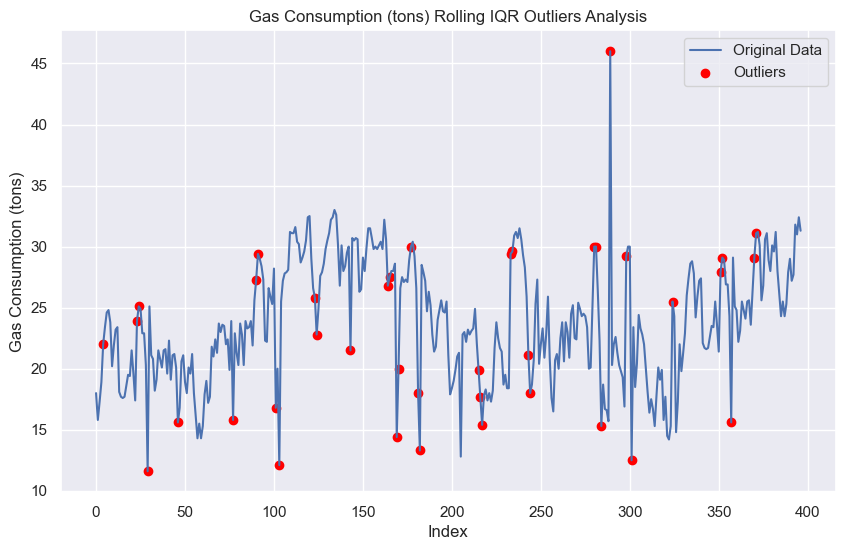

In [278]:

time_series = df['Gas Consumption (tons)']
outliers = detect_rolling_outliers_iqr(time_series)


outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})


plot_time_series_with_outliers(time_series, outliers, 'Gas Consumption (tons)')


---

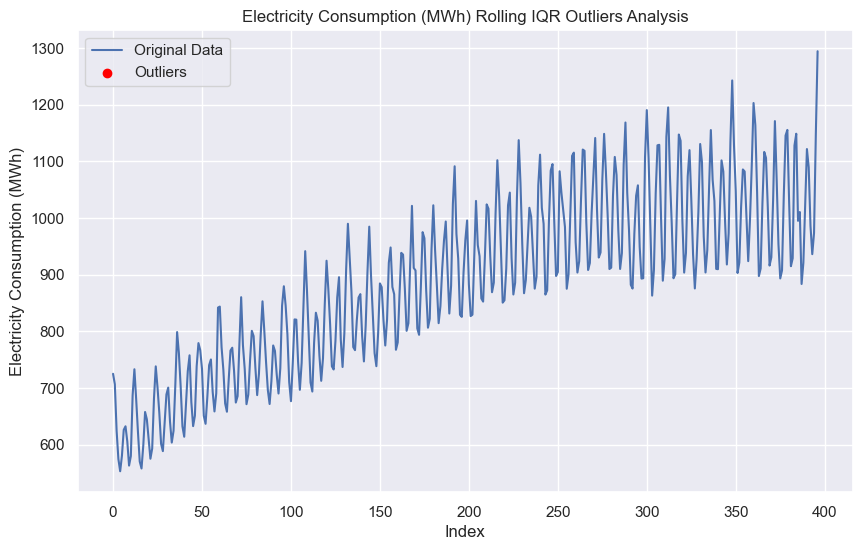

In [279]:
time_series = df['Electricity Consumption (MWh)']
outliers = detect_rolling_outliers_iqr(time_series)

# Print the true outlier values
outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

#outliers_df

plot_time_series_with_outliers(time_series, outliers, 'Electricity Consumption (MWh)')


In [401]:
# time_series = df1['Differenced_electricity']
# outliers = detect_rolling_outliers_iqr(time_series)

# # Print the true outlier values
# outlier_values = time_series[outliers]
# outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

# #outliers_df

# plot_time_series_with_outliers(time_series, outliers, 'Differenced_electricity consumption')


---

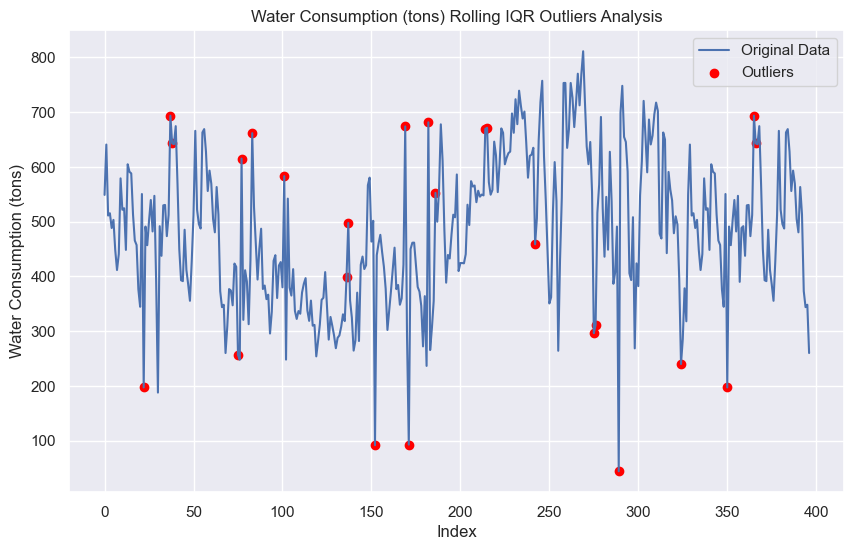

In [281]:
time_series = df['Water Consumption (tons)']
outliers = detect_rolling_outliers_iqr(time_series)

# Print the true outlier values
outlier_values = time_series[outliers]
outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

#outliers_df
plot_time_series_with_outliers(time_series, outliers, 'Water Consumption (tons)')


In [402]:
# time_series = df1['Differenced_water']
# outliers = detect_rolling_outliers_iqr(time_series)

# # Print the true outlier values
# outlier_values = time_series[outliers]
# outliers_df = pd.DataFrame({'Outlier Values': outlier_values})

# #outliers_df

# plot_time_series_with_outliers(time_series, outliers, 'Differenced_water consumption')


---

## **Autocorrelation Analysis**


### *Autocorrelation Function (ACF)*
The ACF plot helps identify the order of the MA (Moving Average) term in the ARIMA model. 

(If the ACF values decrease rapidly after a certain lag, it suggests that the MA term should be included in the model.)

If the ACF values decrease slowly, it suggests the presence of an underlying seasonality, which can be captured by the MA term.

### *Partial Autocorrelation Function (PACF)*

Significant spikes in the PACF plot indicate a direct relationship with the corresponding lag.  

The PACF plot is used to identify the order of the AR (Auto Regressive) term in the ARIMA model.  

If the PACF values drop off after a certain lag, it suggests that the AR term should be included in the model.


PACF tells direct correlation while ACF tells direct + indirect correlation

if there is a spike at a lower value it shows a short term dependency while a spike at a higher value shows a long term dependency


In [177]:
def autocorrelation_plot(data, lags):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot ACF
    plot_acf(data, lags=lags, ax=axes[0])
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title('Autocorrelation Plot')

    # Plot PACF
    plot_pacf(data, lags=lags, ax=axes[1])
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Partial Autocorrelation')
    axes[1].set_title('Partial Autocorrelation Plot')

    plt.tight_layout()
    plt.show()




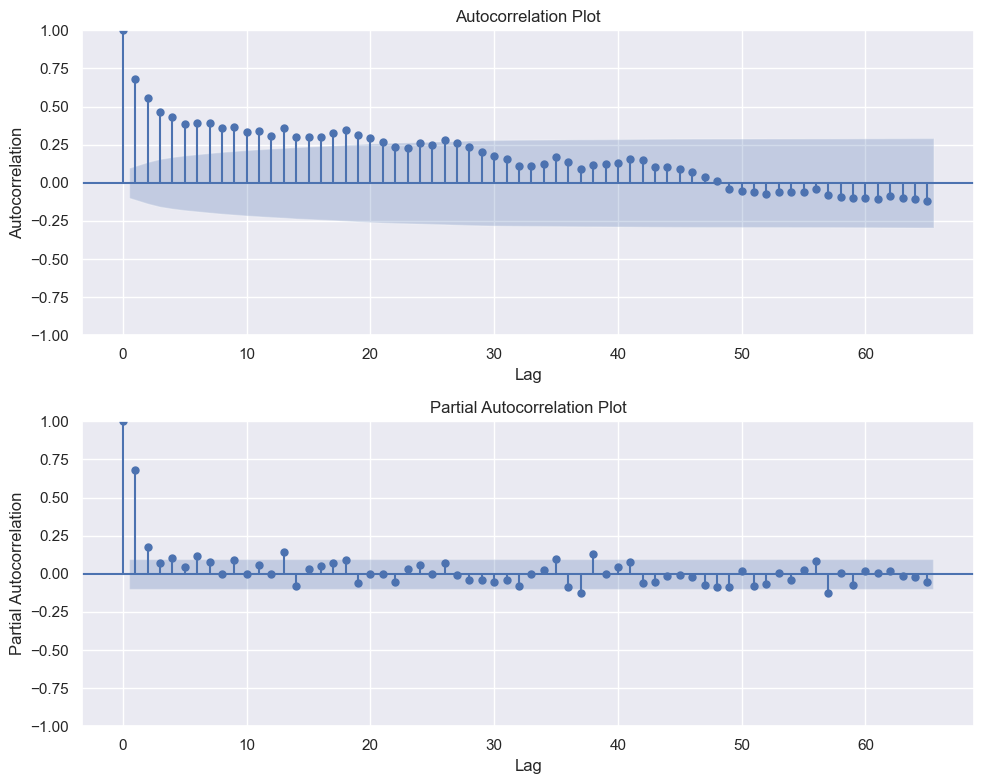

In [403]:
autocorrelation_plot(df['Gas Consumption (tons)'], lags=65)

ACF

start with 0 and during test choose any number above the significance level

PACF

In this case, it is likely that an AR model (Autoregressive Model) would be appropriate for modeling the data, and the value of p (autoregressive order) can be set to 1, based on the significant drop at lag 1 in the PACF plot.

| P (PACF) | D (stationary test) | Q (ACF) |
| :---------------: | :---------------: | :---------------: |
|   0   |   0  |   1   |
|   0-10   |   1 and above  |   0,1   |


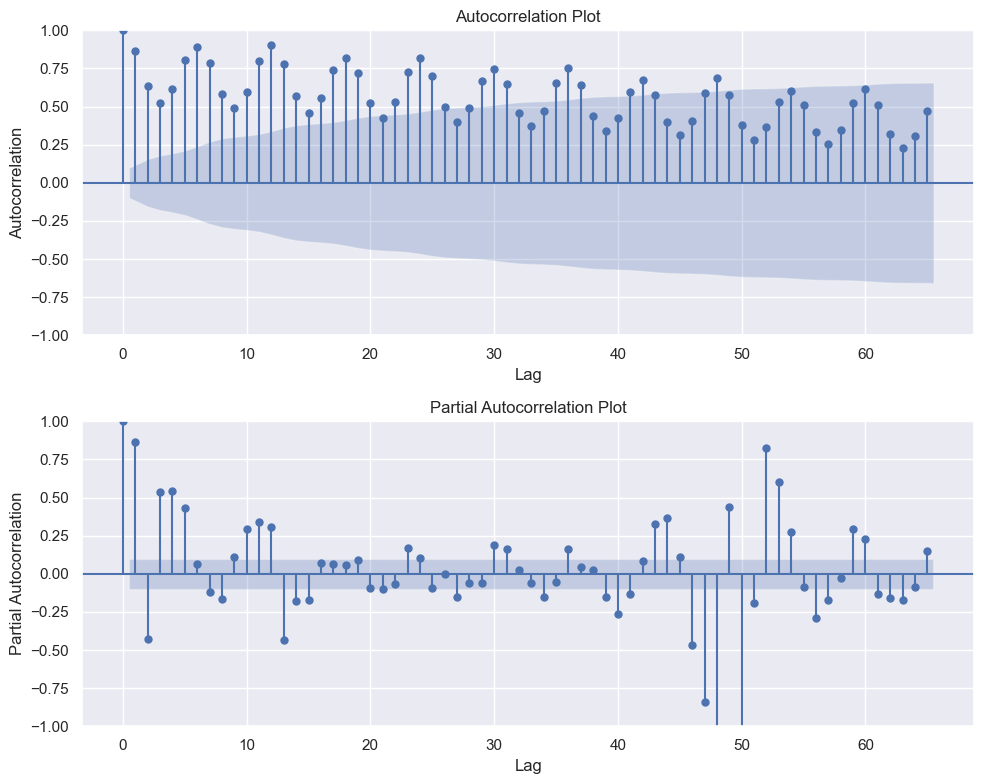

In [179]:
autocorrelation_plot(df['Electricity Consumption (MWh)'], lags=65)

ACF
This suggests that the moving average process is capturing some of the short-term patterns in the data. Therefore, the q value is likely to be small.


q is not likely to be very large: If the ACF exhibits a clear damped oscillation, it indicates that there is no long-term dependency in the data. As the lags increase, the autocorrelation decreases and becomes close to zero. This suggests that the moving average process does not rely heavily on past observations and is not capturing long-term patterns. Thus, the q value is not likely to be very large.
PACF

0 start
test till 5 max 

PACF

since there is a significance drop in the 1st lag, we can say that the AR term is 1

for tuning we could work around that basically 0,1,2

low p


In [400]:
# autocorrelation_plot(df1['Differenced_electricity'], lags=65)

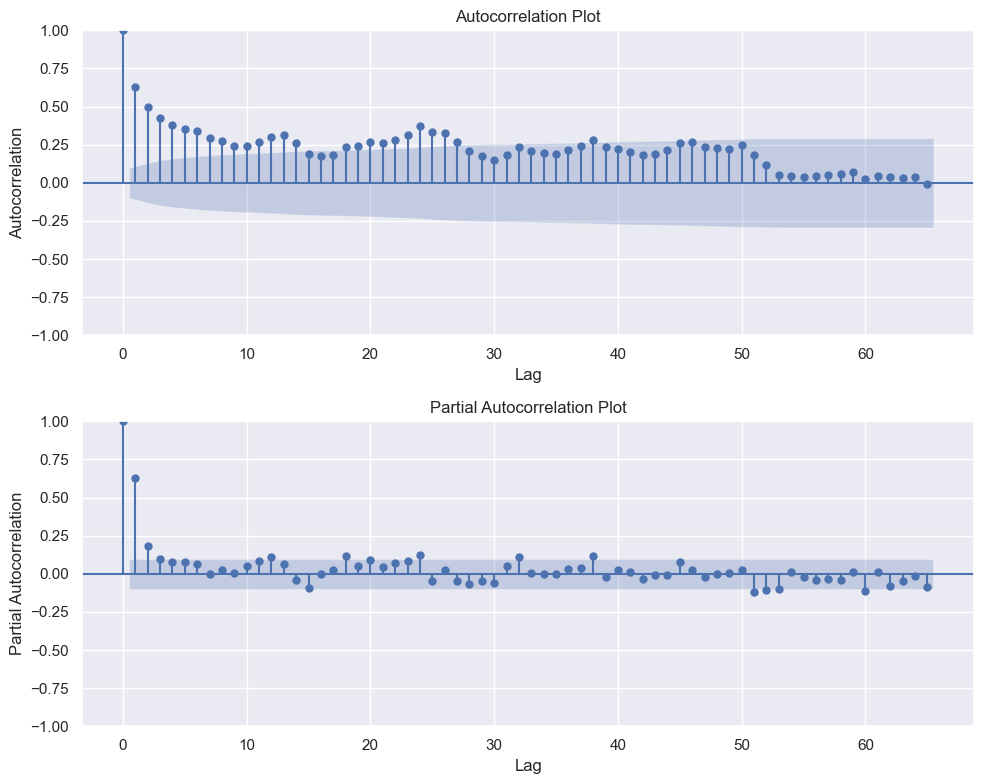

In [181]:
autocorrelation_plot(df['Water Consumption (tons)'], lags=65)

ACF

start with 0 and during test choose any number above the significance level

PACF

In this case, it is likely that an AR model (Autoregressive Model) would be appropriate for modeling the data, and the value of p (autoregressive order) can be set to 1, based on the significant drop at lag 1 in the PACF plot.

In [399]:
# autocorrelation_plot(df1['Differenced_water'], lags=65)

---

# Model Selection

based on the analysis we did above, we can start model selection for our forecasting, we will be using the following models:

- ARIMA
- SARIMA
- Exponential Smoothing
- Holt-Winters Seasonal Smoothing

In [183]:
df

,Gas Consumption (tons),Electricity Consumption (MWh),Water Consumption (tons)
DATE,,,
1990-01-01,18.0,725.1,548.8
1990-02-01,15.8,706.7,640.7
1990-03-01,17.3,624.5,511.1
1990-04-01,18.9,574.7,515.3
1990-05-01,22.0,553.2,488.4
...,...,...,...
2022-09-01,27.7,986.2,513.3
2022-10-01,31.8,936.1,373.1
2022-11-01,31.0,973.4,343.9


ARIMA MODELS

Parameters needed for arima [p,d,q]

based on the analysis i did i found the parameters for the ARIMA model to be 


PARAMETER `(Gas Consumption)` = `[1, 0, 1]`

PARAMETER `(Electricity Consumption)` = `[1, 1, 1]`

PARAMETER `(Water Consumption)` = `[1, 1, 1]`

In [186]:
# from statsmodels.tsa.arima.model import ARIMA

# window_size = 24  
# predictions = pd.DataFrame(index=df.index, columns=['predicted_value'])

# for i in range(window_size, len(df)):
#     train_data = df['Gas Consumption (tons)'].iloc[i-window_size:i]  # Select the current window of data
#     test_data = df['Gas Consumption (tons)'].iloc[i]  # Select the next data point to predict
    
#     # Fit ARIMA model
#     model = ARIMA(train_data, order=(1, 0, 1))  # Adjust the order as needed
#     model_fit = model.fit()
    
#     # Make one-step ahead prediction
#     forecast = model_fit.forecast(steps=1)[0]

#     # Store the predicted value in the DataFrame
#     predictions.loc[test_data, 'predicted_value'] = forecast

# # Plot the actual and predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(df['Gas Consumption (tons)'], label='Actual')
# plt.plot(predictions['predicted_value'], label='Predicted')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('ARIMA Model with Rolling Window')
# plt.show()

In [187]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA

# # Assuming your DataFrame is named 'df' with columns as the features

# window_size = 24  # Define the window size

# # Create an empty DataFrame to store the predicted values
# predictions = pd.DataFrame(index=df.index)

# # Loop through each column in the DataFrame
# for col in df.columns:
#     # Perform ARIMA modeling with rolling window
#     for i in range(window_size, len(df)):
#         train_data = df[col].iloc[i-window_size:i]  # Select the current window of data
#         test_data = df[col].iloc[i]  # Select the next data point to predict

#         # Fit ARIMA model
#         model = ARIMA(train_data, order=(2, 1, 1))  # Adjust the order as needed
#         model_fit = model.fit()

#         # Make one-step ahead prediction
#         forecast = model_fit.forecast(steps=1)[0]

#         # Store the predicted value in the DataFrame
#         predictions.loc[test_data, col] = forecast

#     # Plot the actual and predicted values for the current feature
#     plt.figure(figsize=(8, 6))
#     plt.plot(df[col], label='Actual')
#     plt.plot(predictions[col], label='Predicted')
#     plt.legend()
#     plt.xlabel('Time')
#     plt.ylabel('Value')
#     plt.title('ARIMA Model with Rolling Window: ' + col)
#     plt.show()

In [188]:
# def rolling_arima_forecast(df, target_feature, p, d, q, window_size):
#     # Initialize an empty DataFrame to store the forecasts
#     forecast_df = pd.DataFrame(columns=['Date', f'{target_feature} Forecast'])

#     # Perform rolling forecast
#     for i in range(len(df) - window_size):
#         # Split the data into train and test sets
#         train = df[target_feature].iloc[i:i+window_size]
#         test = df[target_feature].iloc[i+window_size:i+window_size+1]

#         # Fit the ARIMA model
#         model = ARIMA(train, order=(p, d, q))
#         model_fit = model.fit()

#         # Make the forecast
#         forecast = model_fit.forecast(steps=1).iloc[0]
#         # Append the forecast to the DataFrame
#         forecast_df = forecast_df.append({'Date': test.index[0], f'{target_feature} Forecast': forecast}, ignore_index=True)

#     return forecast_df

In [189]:
# target_feature = 'Gas Consumption (tons)'

# forecast_df = rolling_arima_forecast(df, target_feature, 1, 0, 1, 24)
# forecast_df = forecast_df.set_index('Date')


# plt.plot(df.index, df[target_feature], label='Actual')
# plt.plot(forecast_df.index, forecast_df[f'{target_feature} Forecast'], label='Forecast')
# plt.xlabel('Date')
# plt.ylabel(target_feature)
# plt.title('Rolling ARIMA Forecast')
# plt.legend()
# plt.show()

# Print the forecasted values
# print(forecast_df)

In [190]:
# target_feature = 'Electricity Consumption (MWh)'

# forecast_df = rolling_arima_forecast(df, target_feature, 1, 1, 1, 24)
# forecast_df = forecast_df.set_index('Date')


# plt.plot(df.index, df[target_feature], label='Actual')
# plt.plot(forecast_df.index, forecast_df[f'{target_feature} Forecast'], label='Forecast')
# plt.xlabel('Date')
# plt.ylabel(target_feature)
# plt.title('Rolling ARIMA Forecast')
# plt.legend()
# plt.show()


In [191]:
# target_feature = 'Water Consumption (tons)'

# forecast_df = rolling_arima_forecast(df, target_feature, 1, 1, 1, 24)
# forecast_df = forecast_df.set_index('Date')


# plt.plot(df.index, df[target_feature], label='Actual')
# plt.plot(forecast_df.index, forecast_df[f'{target_feature} Forecast'], label='Forecast')
# plt.xlabel('Date')
# plt.ylabel(target_feature)
# plt.title('Rolling ARIMA Forecast')
# plt.legend()
# plt.show()

In [192]:
# Assuming you have a DataFrame named 'df' with your time series data

# Set the window size and test size
# window_size = 24
# test_size = 3

# # Initialize lists to store the train and test data for each iteration
# train_data = []
# test_data = []

# # Perform rolling holdout cross-validation
# for i in range(window_size, len(df) - test_size + 1):
#     train_data.append(df['Gas Consumption (tons)'].iloc[:i])
#     test_data.append(df['Gas Consumption (tons)'].iloc[i:i+test_size])

# train_sizes = []
# test_sizes = []
# mape_scores = []
# mae_scores = []

# for i in range(len(train_data)):
#     # Get the train and test data for the current iteration
#     train = train_data[i]
#     test = test_data[i]
    
#     # Get the sizes of train and test data
#     train_sizes.append(len(train))
#     test_sizes.append(len(test))
    
#     # Initialize the ARIMA model
#     model = ARIMA(train, order=(1, 0, 1))
    
#     # Fit the ARIMA model to the training data
#     model_fit = model.fit()
    
#     # Make predictions for the test data
#     predictions = model_fit.forecast(steps=len(test))

#     # print(predictions)

#     mape = mean_absolute_percentage_error(test, predictions)
#     mae = mean_absolute_error(test, predictions)
    
#     # Store the scores
#     mape_scores.append(mape)
#     mae_scores.append(mae)
    
#     # Print the results
#     print(f"Iteration {i+1}:")
#     print("Train Size:", len(train))
#     print("Test Size:", len(test))
#     print("MAPE:", mape)
#     print("MAE:", mae)
#     print()



In [193]:

# import pandas as pd
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# from math import sqrt


# target_column = 'Gas Consumption (tons)'

# # Assuming you have a DataFrame named 'df' with your time series data
# # And a variable 'target_column' representing the column to be forecasted

# # Set the window size
# min_window_size = 24  # Use the previous 24 observations for training
# window_step = 1  # Step size for expanding the window

# # Initialize lists to store the predictions and actual values
# predictions = []
# actual_values = []
# train_sizes = []
# test_sizes = []

# # Perform one-step cross-validation
# for i in range(min_window_size, len(df)):
#     # Split the data into training and testing sets
#     train_window_size = min_window_size + ((i - min_window_size) // window_step) * window_step
#     test_window_size = train_window_size + 1

#     train_data = df[target_column].iloc[i-train_window_size:i]
#     test_data = df[target_column].iloc[i:i+test_window_size] 
    
#     train_sizes.append(len(train_data))
#     test_sizes.append(len(test_data))

#     # Initialize the ARIMA model
#     model = ARIMA(train_data, order=(1, 0, 1))  # Example: ARIMA(1, 0, 0)
    
#     # Fit the ARIMA model to the training data
#     model_fit = model.fit()
    
#     # Make the one-step ahead forecast
#     forecast = model_fit.forecast(steps=1)
#     prediction = forecast.iloc[0]
    
#     # Collect the predicted and actual values
#     predictions.append(prediction)
#     actual_values.append(test_data.values[0])

    

# predictions = list(predictions)
# actual_values = list(actual_values)

# # Calculate evaluation metrics
# mae = mean_absolute_error(actual_values, predictions)
# # Calculate MAPE
# mape = 100 * mean_absolute_error(actual_values, predictions) / sum(actual_values)

# # Print the scores and train/test sizes for each iteration
# for i in range(len(predictions)):
#     print(f"Iteration {i+1}:")
#     print("Train Size:", train_sizes[i])
#     print("Test Size:", test_sizes[i])
#     print("MAE:", mae)
#     print("MAPE:", mape)
#     print()


In [194]:
# I THINK THIS IS IT DYNAMIC EXPANDING WINDOW (still important prototype)
# Set the initial window size, number of time steps to predict, and the order of the ARIMA model
# from sklearn.metrics import mean_absolute_error
# from math import sqrt

# initial_window_size = 24
# num_steps = 3
# order = (1, 0, 1)  # Example ARIMA order (p, d, q)

# # Initialize an empty list to store the predicted values
# predictions = []
# mape_scores = []
# mae_scores = []


# # Perform multi-step ahead forecasting with expanding window
# window_size = initial_window_size
# for i in range(initial_window_size, len(df), num_steps):
#     # Get the current window of data
#     train = df['Gas Consumption (tons)'].iloc[i - window_size:i]
#     test = df['Gas Consumption (tons)'].iloc[i:i + num_steps]

#     # Initialize the ARIMA model
#     model = ARIMA(train, order=order)

#     # Fit the ARIMA model to the training data
#     model_fit = model.fit()

#     # Make predictions for the desired number of time steps
#     forecast = model_fit.forecast(steps=num_steps)


#     predictions.extend(forecast)

#     if len(test) == len(forecast):
#         mape = mean_absolute_percentage_error(test, forecast)
#         mae = mean_absolute_error(test, forecast)

#         # Append the scores to the respective lists
#         mape_scores.append(mape)
#         mae_scores.append(mae)

#     # Update the window size for the next iteration
#     window_size += num_steps

# # Create a DataFrame with the predicted values
# predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
# scores_df = pd.DataFrame({'MAPE': mape_scores, 'MAE': mae_scores})
# scores_df.index = [f"iteration {i+1}" for i in range(len(scores_df))]


# # Print the predictions DataFrame
# average_mape = scores_df['MAPE'].mean()
# average_mae = scores_df['MAE'].mean()


# display(predictions_df)



# display(scores_df)

In [283]:
# def mean_absolute_percentage_error(y_true, y_pred):
#     """
#     Calculate the Mean Absolute Percentage Error (MAPE) between two arrays.

#     Parameters:
#     y_true : array-like
#         The true values.
#     y_pred : array-like
#         The predicted values.

#     Returns:
#     float
#         The mean absolute percentage error.
#     """
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0

In [343]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error


# Multi step forecasting with expanding window (dynamic expanding window)

def rolling_forecast(df, target_column, initial_window_size, num_steps, order, seasonal_order=None):
    predictions = []
    aic_scores  = []
    mae_scores = []

    window_size = initial_window_size
    for i in range(initial_window_size, len(df), num_steps):
        
        # Get the current window of data
        train = df[target_column].iloc[i - window_size:i]
        test = df[target_column].iloc[i:i + num_steps]
        # print(len(train))
        
        if seasonal_order == None:
            model = ARIMA(train, order=order)
        elif seasonal_order != None:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)

        
        model_fit = model.fit()


        # Make predictions for the desired number of time steps
        forecast = model_fit.forecast(steps=num_steps)

        predictions.extend(forecast)

        if len(test) == len(forecast):
            mae = mean_absolute_error(test, forecast)
            aic = model_fit.aic

            aic_scores.append(aic)

            mae_scores.append(mae)

        # Update the window size for the next iteration
        window_size += num_steps

    predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
    scores_df = pd.DataFrame({'AIC': aic_scores, 'MAE': mae_scores})
    scores_df.index = [f"Iteration {i+1}" for i in range(len(scores_df))]

    average_aic = scores_df['AIC'].mean()
    average_mae = scores_df['MAE'].mean()

    return predictions_df, scores_df, average_aic, average_mae


# ARIMA example

# SARIMA example
# seasonal_order = (p, d, q, s) - replace with the appropriate values
# predictions_df, scores_df, average_mape, average_mae = rolling_forecast(df, 'Gas Consumption (tons)', 24, 3, 'SARIMA', (1, 0 , 1), seasonal_order=(1, 0, 1, 12))

# # Print the predictions DataFrame
# print(predictions_df)

# # Print the scores DataFrame
# print(scores_df)

# # Print the average MAPE and MAE scores
# print("Average MAPE:", average_mape)
# print("Average MAE:", average_mae)

# for the dates

def generate_dates(start_date, num_iterations):
    
    dates = []

    # Loop to generate new dates
    current_date = start_date
    for _ in range(num_iterations):
        # Add one month to the current date
        # current_date += datetime.timedelta(days=30)
        current_date += relativedelta(months=1)
        
        dates.append(current_date)

    
    df = pd.DataFrame({'Date': dates})


    df['Date'] = pd.to_datetime(df['Date'])

    return df


analysis = pd.DataFrame(columns=['Feature', 'Average AIC', 'Average MAE'])


---

#### Gas consumption

In [344]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Gas Consumption (tons)', 24, 3, (1, 0, 1))

display(predictions_df)
display(scores_df)
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

analysis = analysis.append({'Feature': 'Gas Consumption (tons)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,23.964889
1,21.991233
2,21.151577
3,21.684850
4,21.237088
...,...
370,26.301111
371,25.914580
372,30.068869
373,29.177168


,AIC,MAE
Iteration 1,111.685164,1.930767
Iteration 2,122.499245,3.853091
Iteration 3,147.059552,6.537814
Iteration 4,172.777164,1.641662
Iteration 5,185.696561,0.524466
...,...,...
Iteration 120,2054.632742,2.062813
Iteration 121,2068.682925,1.842335
Iteration 122,2082.319147,1.495376
Iteration 123,2096.284183,2.157688


Average AIC: 1086.903777927638
Average MAE: 3.003888585287556


In [292]:
start_date = datetime.date(1992, 1, 1)
num_iterations = len(predictions_df)

result = generate_dates(start_date, num_iterations)
display(result.dtypes)
display(result)

Date    datetime64[ns]
dtype: object

,Date
0,1992-02-01
1,1992-03-01
2,1992-04-01
3,1992-05-01
4,1992-06-01
...,...
370,2022-12-01
371,2023-01-01
372,2023-02-01
373,2023-03-01


In [345]:
# set the dates i created as the index
predictions = predictions_df.set_index(result['Date'])

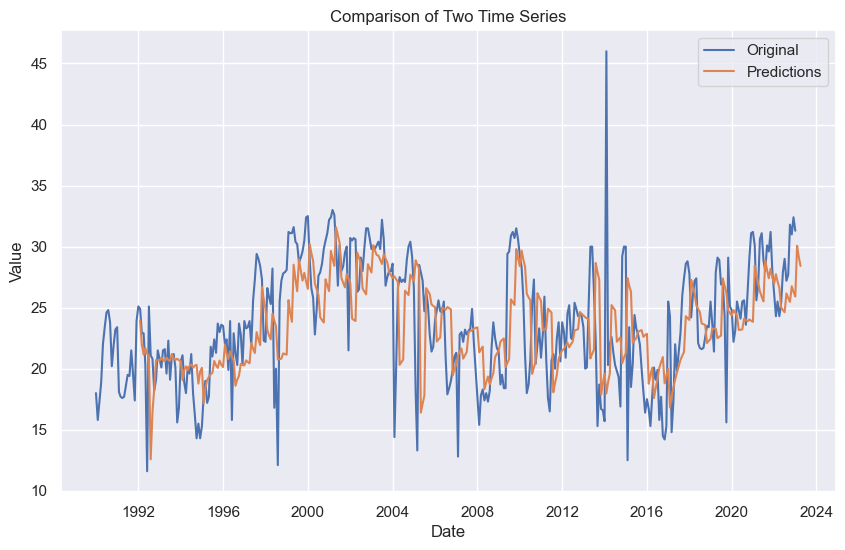

In [346]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Gas Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

---

#### Water Consumption

In [301]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Water Consumption (tons)', 24, 3, 'ARIMA', (1, 1, 1))

display(predictions_df)
display(scores_df)
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)
analysis = analysis.append({'Feature': 'Water Consumption (tons)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,306.405214
1,416.990347
2,350.742151
3,501.061485
4,517.062701
...,...
370,527.218199
371,528.972945
372,426.904781
373,461.047684


,AIC,MAE
Iteration 1,279.080635,141.320763
Iteration 2,314.866066,56.433495
Iteration 3,349.300710,127.712183
Iteration 4,392.368050,70.666988
Iteration 5,426.573916,148.886435
...,...,...
Iteration 120,4600.194963,63.290326
Iteration 121,4636.294850,68.425814
Iteration 122,4670.526015,37.861414
Iteration 123,4704.238768,31.005758


Average AIC: 2501.968086011198
Average MAE: 85.85484558421344


In [203]:
start_date = datetime.date(1992, 1, 1)
num_iterations = len(predictions_df)

result = generate_dates(start_date, num_iterations)
display(result.dtypes)
display(result)

Date    datetime64[ns]
dtype: object

,Date
0,1992-01-31
1,1992-03-01
2,1992-03-31
3,1992-04-30
4,1992-05-30
...,...
370,2022-06-22
371,2022-07-22
372,2022-08-21
373,2022-09-20


In [204]:
predictions = predictions_df.set_index(result['Date'])

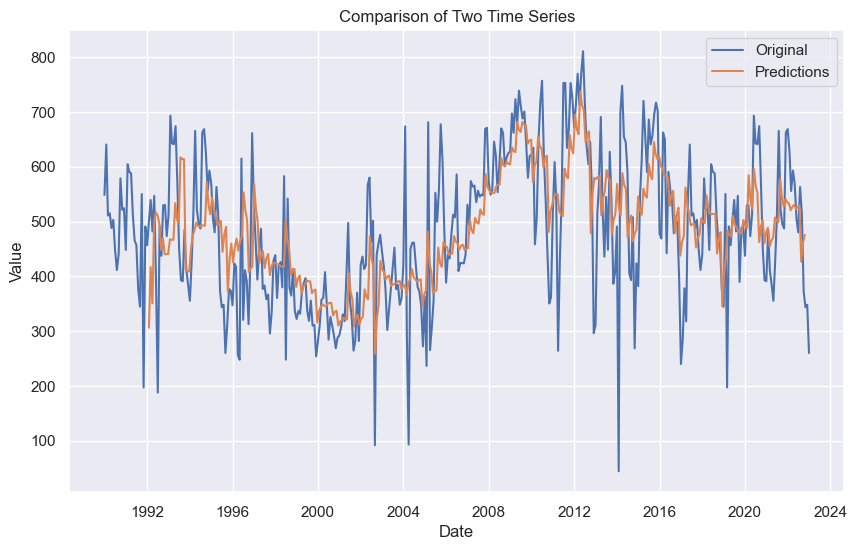

In [205]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Water Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

---

Electricity Consumption

In [302]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Electricity Consumption (MWh)', 24, 3, 'ARIMA', (1, 1, 1))

display(predictions_df)
display(scores_df)
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)
analysis = analysis.append({'Feature': 'Electricity Consumption (MWh)', 'Average AIC': average_aic, 'Average MAE': average_mae}, ignore_index=True)


,Prediction
0,721.204731
1,725.395436
2,725.836640
3,651.645410
4,650.892897
...,...
370,946.891907
371,946.741697
372,1238.208887
373,1244.307567


,AIC,MAE
Iteration 1,234.999285,37.175782
Iteration 2,264.299336,41.368027
Iteration 3,294.579360,26.748713
Iteration 4,324.085392,62.260602
Iteration 5,354.692097,45.038798
...,...,...
Iteration 120,4247.611906,78.629230
Iteration 121,4286.150436,197.541045
Iteration 122,4323.060367,119.481551
Iteration 123,4365.679441,62.116601


Average AIC: 2267.8054537663015
Average MAE: 66.57167844362509


In [207]:
predictions = predictions_df.set_index(result['Date'])

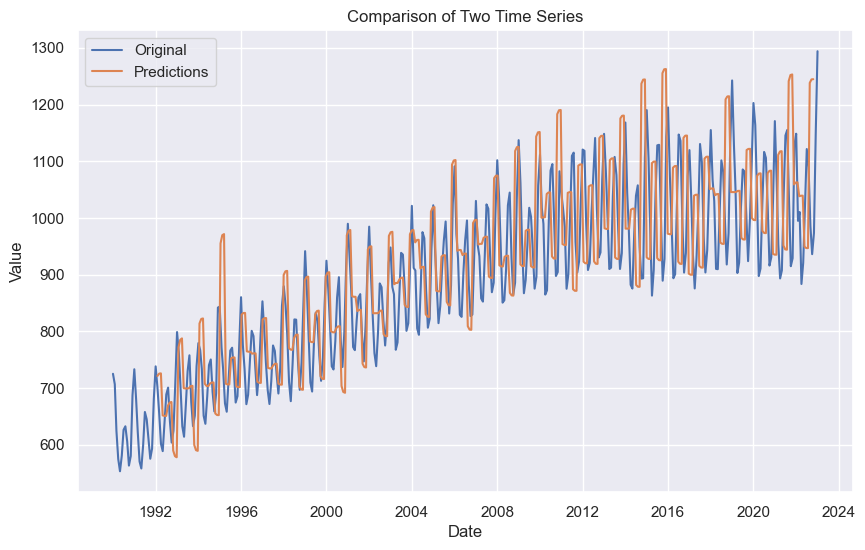

In [208]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Electricity Consumption (MWh)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

In [303]:
analysis

,Feature,Average AIC,Average MAE
0,Gas Consumption (tons),1086.903778,3.003889
1,Water Consumption (tons),2501.968086,85.854846
2,Electricity Consumption (MWh),2267.805454,66.571678


---

SARIMA Models

In [210]:
# seasonal_order = (p, d, q, s) - replace with the appropriate values
# for p and q look at the intervals of each season basically at each 12
# for d if there is seasonality present start with 1 if not start with 0 

predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Gas Consumption (tons)', 24, 3, 'SARIMA', (1, 0 , 1), seasonal_order=(1, 1, 1, 12))


# # Print the predictions DataFrame
display(predictions_df)

# # Print the scores DataFrame
display(scores_df)

# # Print the average MAPE and MAE scores
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,28.808186
1,20.401352
2,18.101107
3,22.852034
4,23.699226
...,...
370,26.813665
371,26.082853
372,31.015019
373,28.910884


,AIC,MAE
Iteration 1,64.415717,4.335242
Iteration 2,82.444142,5.403388
Iteration 3,103.669918,6.138083
Iteration 4,124.684099,1.846583
Iteration 5,138.924349,2.125588
...,...,...
Iteration 120,2034.975353,2.091877
Iteration 121,2048.906260,1.595295
Iteration 122,2062.789498,1.544690
Iteration 123,2077.110910,1.818279


Average MAPE: 1058.4631689775908
Average MAE: 3.184519358924183


In [211]:
predictions = predictions_df.set_index(result['Date'])

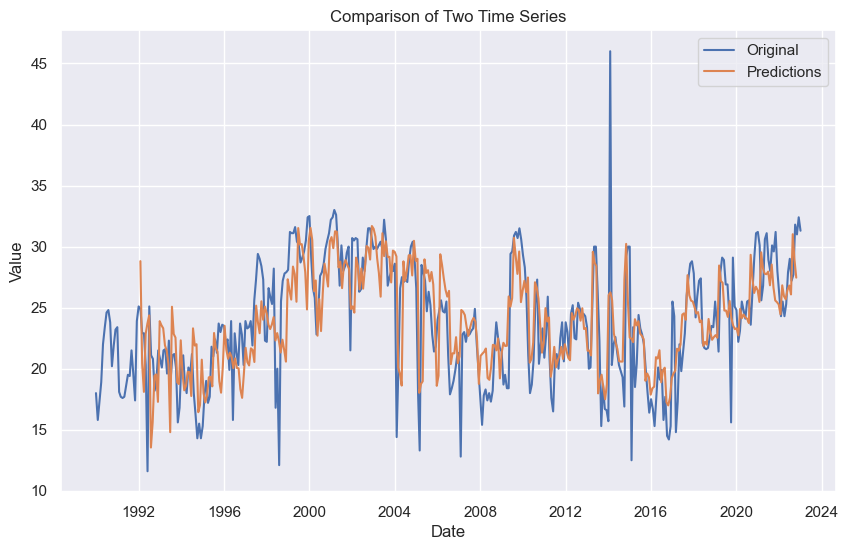

In [212]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Gas Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

---

electricity consumption

In [304]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Electricity Consumption (MWh)', 24, 3, 'SARIMA', (1, 1 , 1), seasonal_order=(1, 1, 1, 12))


# # Print the predictions DataFrame
display(predictions_df)

# # Print the scores DataFrame
display(scores_df)

# # Print the average MAPE and MAE scores
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,740.163264
1,654.744452
2,620.226460
3,592.747838
4,572.880843
...,...
370,939.451853
371,1092.862997
372,1200.648083
373,1084.111735


,AIC,MAE
Iteration 1,100.764627,27.897451
Iteration 2,125.214539,18.499241
Iteration 3,148.358120,9.142202
Iteration 4,174.098094,10.671665
Iteration 5,196.118343,28.004270
...,...,...
Iteration 120,3366.560670,31.266922
Iteration 121,3399.400084,63.400666
Iteration 122,3451.583404,11.526146
Iteration 123,3477.550243,18.290981


Average AIC: 1749.212390363192
Average MAE: 21.536888477907656


In [214]:
predictions = predictions_df.set_index(result['Date'])

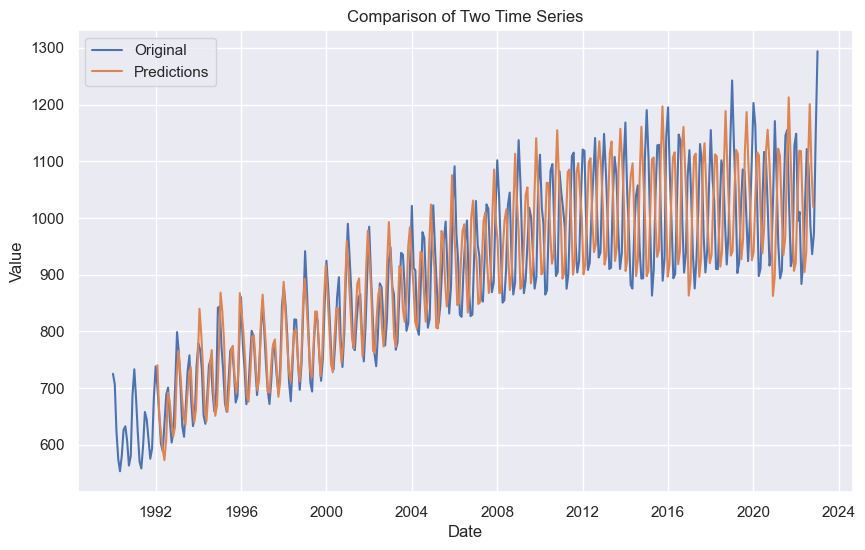

In [215]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Electricity Consumption (MWh)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

---


water consumption

In [216]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Water Consumption (tons)', 24, 3, 'SARIMA', (1, 1 , 1), seasonal_order=(1, 1, 1, 12))


# # Print the predictions DataFrame
display(predictions_df)

# # Print the scores DataFrame
display(scores_df)

# # Print the average MAPE and MAE scores
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,233.264568
1,456.485578
2,554.596948
3,502.053078
4,443.709411
...,...
370,490.740160
371,484.888867
372,384.593776
373,456.667848


,AIC,MAE
Iteration 1,143.668918,94.648934
Iteration 2,179.472849,52.349013
Iteration 3,213.786343,155.216151
Iteration 4,256.242565,97.326799
Iteration 5,293.030754,124.823117
...,...,...
Iteration 120,4492.811872,88.687784
Iteration 121,4530.645581,96.887652
Iteration 122,4566.292095,52.937199
Iteration 123,4600.963348,37.163935


Average MAPE: 2384.7867244349977
Average MAE: 91.49025384320592


In [217]:
predictions = predictions_df.set_index(result['Date'])

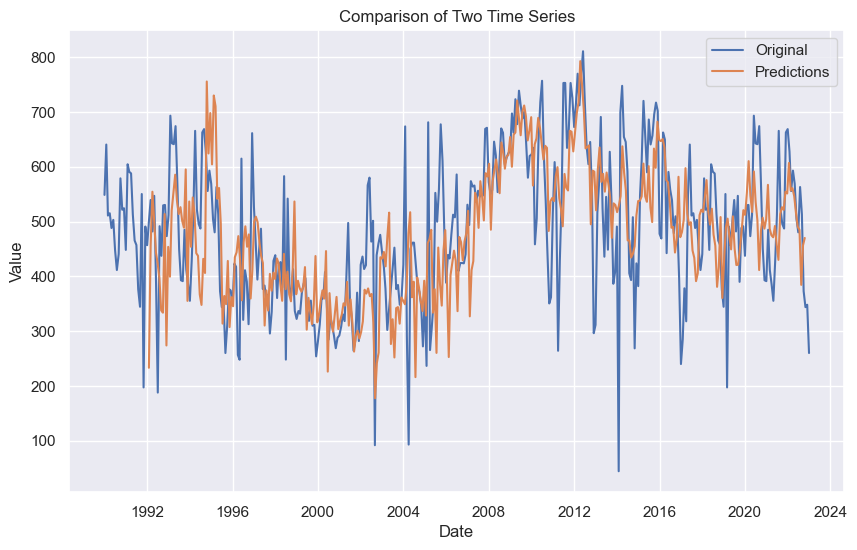

In [218]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Water Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

---

## Holt-Winters Exponential Smoothing

In [305]:

def rolling_forecast_smoothing(df, target_column, initial_window_size, num_steps, smoothing_level, smoothing_slope=None, damping_slope=None, seasonal_periods=None):
    predictions = []
    aic_scores = []
    mae_scores = []

    window_size = initial_window_size
    for i in range(initial_window_size, len(df), num_steps):
        # Get the current window of data
        train = df[target_column].iloc[i - window_size:i]
        test = df[target_column].iloc[i:i + num_steps]

        # Initialize the ExponentialSmoothing model
        model = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, trend="additive", seasonal="additive")

        # Fit the model to the training data
        model_fit = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, damping_slope=damping_slope)

        # Make predictions for the desired number of time steps
        forecast = model_fit.forecast(steps=num_steps)

        predictions.extend(forecast)

        if len(test) == len(forecast):
            aic = model_fit.aic
            mae = mean_absolute_error(test, forecast)

            aic_scores.append(aic)
            mae_scores.append(mae)

        # Update the window size for the next iteration
        window_size += num_steps

    predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
    scores_df = pd.DataFrame({'AIC': aic_scores, 'MAE': mae_scores})
    scores_df.index = [f"Iteration {i+1}" for i in range(len(scores_df))]

    average_mape = scores_df['AIC'].mean()
    average_mae = scores_df['MAE'].mean()

    return predictions_df, scores_df, average_mape, average_mae

In [306]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Gas Consumption (tons)', 24, 3, 0.2, 0.1, 0.9, 12)

display(predictions_df)


display(scores_df)

# Print the average MAPE and MAE scores
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,18.123096
1,14.294111
2,14.770959
3,20.253843
4,21.966269
...,...
370,27.686353
371,27.164284
372,30.326161
373,29.167657


,AIC,MAE
Iteration 1,58.672358,8.570611
Iteration 2,81.337247,5.312723
Iteration 3,98.030226,2.021850
Iteration 4,102.804112,1.385957
Iteration 5,106.585090,1.628922
...,...,...
Iteration 120,1063.954520,1.135833
Iteration 121,1069.597424,5.009343
Iteration 122,1078.052516,2.249567
Iteration 123,1084.449194,0.986131


Average MAPE: 560.5191056141571
Average MAE: 3.2927999854096153


In [309]:
predictions = predictions_df.set_index(result['Date'])

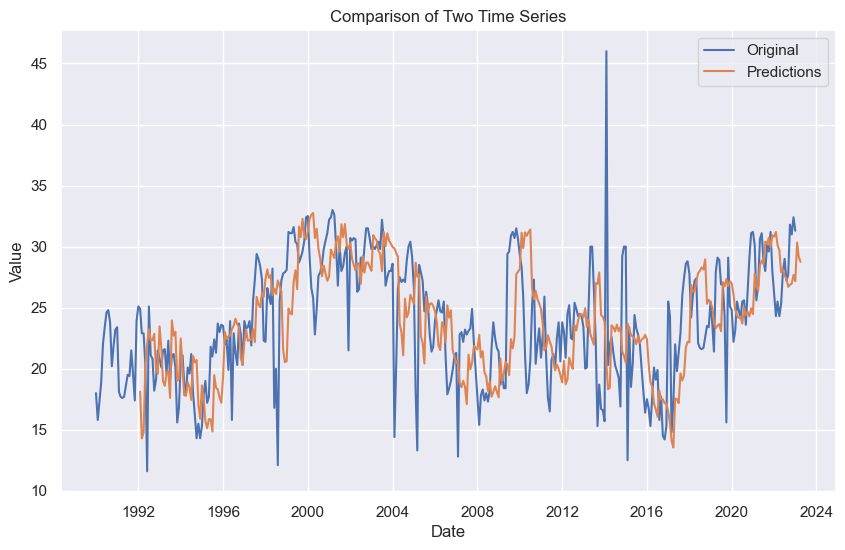

In [312]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Gas Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

---

In [223]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Electricity Consumption (MWh)', 24, 3, 0.2, 0.1, 0.9, 12)

display(predictions_df)


display(scores_df)

# Print the average MAPE and MAE scores
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,737.830931
1,702.273786
2,632.549466
3,586.478222
4,570.049456
...,...
370,930.305774
371,1076.557214
372,1186.148124
373,1088.246404


,MAPE,MAE
Iteration 1,1.292792,8.531129
Iteration 2,3.676097,22.643930
Iteration 3,2.830277,19.574876
Iteration 4,1.296119,8.806002
Iteration 5,3.084297,23.198954
...,...,...
Iteration 120,2.714154,26.749940
Iteration 121,5.586870,57.836439
Iteration 122,1.100500,10.446577
Iteration 123,0.892788,9.742873


Average MAPE: 2.6569128512792832
Average MAE: 24.495368382834698


In [224]:
predictions = predictions_df.set_index(result['Date'])

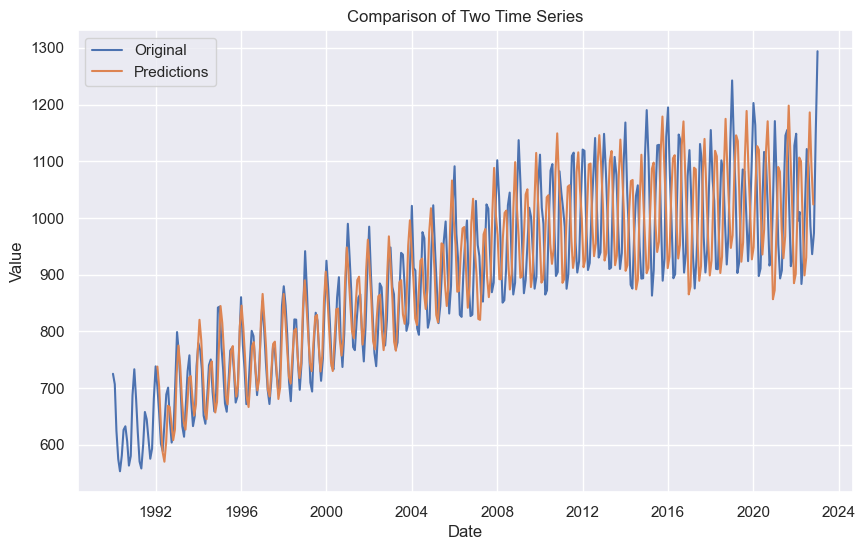

In [225]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Electricity Consumption (MWh)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

In [226]:
predictions_df, scores_df, average_aic, average_mae = rolling_forecast_smoothing(df, 'Water Consumption (tons)', 24, 3, 0.2, 0.1, 0.9, 12)

display(predictions_df)


display(scores_df)

# Print the average MAPE and MAE scores
print("Average AIC:", average_aic)
print("Average MAE:", average_mae)

,Prediction
0,422.570434
1,543.563171
2,468.878708
3,482.790803
4,428.786603
...,...
370,485.898050
371,481.073163
372,373.458685
373,415.170694


,MAPE,MAE
Iteration 1,9.663274,49.004676
Iteration 2,8.935686,46.219425
Iteration 3,55.113809,156.881589
Iteration 4,13.995074,73.588312
Iteration 5,13.959199,89.156593
...,...,...
Iteration 120,24.076609,143.395089
Iteration 121,20.315148,130.773039
Iteration 122,18.439133,96.489722
Iteration 123,26.479786,134.570917


Average MAPE: 25.442770240898305
Average MAE: 97.56735321349835


In [227]:
predictions = predictions_df.set_index(result['Date'])

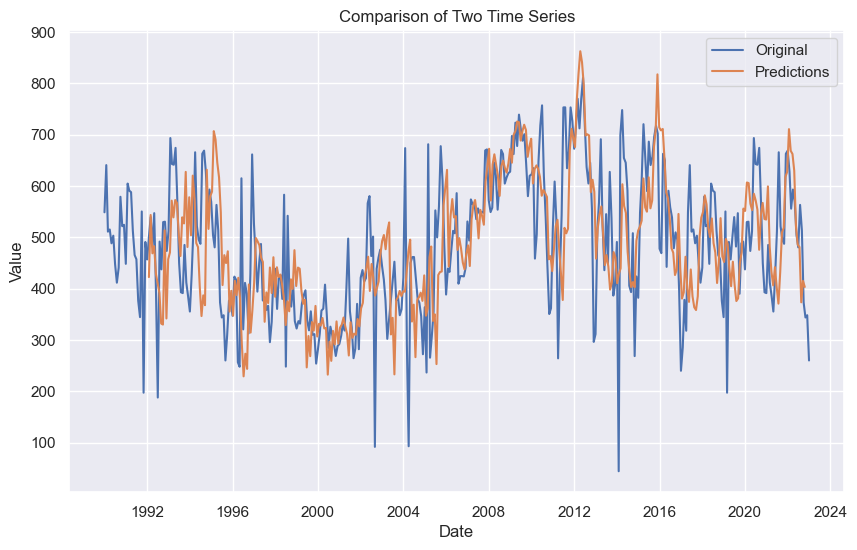

In [228]:
plt.figure(figsize=(10, 6))

plt.plot(df.index, df['Water Consumption (tons)'], label='Original')

plt.plot(predictions.index, predictions['Prediction'], label='Predictions')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Comparison of Two Time Series')

plt.legend()

plt.show()

---

## Prophet (extra)

In [265]:
# import pandas as pd
# from sklearn.metrics import mean_absolute_error

# def rolling_forecast_prophet(df, target_column, initial_window_size, num_steps):
#     predictions = []
#     aic_scores = []
#     mae_scores = []

#     window_size = initial_window_size
#     for i in range(initial_window_size, len(df), num_steps):
#         # Get the current window of data
#         train = df.iloc[:i]

#         # Prepare the data for Prophet
#         train_prophet = train.rename(columns={target_column: 'y'})
#         train_prophet['ds'] = train_prophet.index

#         # Create the Prophet model
#         model = Prophet()

#         # Fit the model to the training data
#         model.fit(train_prophet)

#         if i + num_steps < len(train_prophet):
#             num_steps_iter = num_steps
#         else:
#             num_steps_iter = len(df) - i

#         # Make predictions for the desired number of time steps
#         future_dates = pd.date_range(start=train.index[-1], periods=num_steps_iter + 1, closed='right')
#         future_dates = future_dates[1:]  # Exclude the last date of the training data
#         future_df = pd.DataFrame({'ds': future_dates})
#         forecast = model.predict(future_df)['yhat'].values

#         predictions.extend(forecast)

#         # Calculate AIC and MAE for evaluation
#         if len(train) >= window_size:
#             # aic_scores.append(model.aic)
#             mae = mean_absolute_error(df[target_column].iloc[i:i + num_steps], forecast)
#             mae_scores.append(mae)

#     predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
#     scores_df = pd.DataFrame({'MAE': mae_scores})
#     scores_df.index = [f"Iteration {i+1}" for i in range(len(scores_df))]

#     # average_aic = scores_df['AIC'].mean()
#     average_mae = scores_df['MAE'].mean()

#     return predictions_df, scores_df, average_aic, average_mae

In [267]:
# target_column = 'Gas Consumption (tons)'
# initial_window_size = 24  # Initial size of the training window
# num_steps = 3  # Number of steps to forecast ahead

# # Apply the rolling_forecast_prophet function
# predictions_df, scores_df, average_mae = rolling_forecast_prophet(df, target_column, initial_window_size, num_steps)

# # Print the forecasted values
# print(predictions_df)

# # Print the AIC scores and MAE scores for each iteration
# print(scores_df)

# # Print the average AIC and average MAE across all iterations
# print("Average AIC:", average_aic)
# print("Average MAE:", average_mae)

---

## Hyperparameter tuning

In [322]:
def rolling_forecast(df, target_column, initial_window_size, num_steps, model_type, p_range, d_range, q_range, seasonal_order=None):
    predictions = []
    result_df = pd.DataFrame(columns=['p', 'd', 'q', 'AIC', 'MAE'])

    window_size = initial_window_size
    for i in range(initial_window_size, len(df), num_steps):
        # Get the current window of data
        train = df[target_column].iloc[i - window_size:i]
        test = df[target_column].iloc[i:i + num_steps]

        # Hyperparameter tuning with nested loops
        for p in p_range:
            for d in d_range:
                for q in q_range:
                    try:
                        if model_type == 'ARIMA':
                            model = ARIMA(train, order=(p, d, q))
                        elif model_type == 'SARIMA':
                            model = SARIMAX(train, order=(p, d, q), seasonal_order=seasonal_order)

                        model_fit = model.fit()

                        forecast = model_fit.forecast(steps=num_steps)
                        if len(test ) ==  len(forecast):
                            mae = mean_absolute_error(test, forecast)
                            aic = model_fit.aic

                            result_df = result_df.append({'p': p, 'd': d, 'q': q, 'AIC': aic, 'MAE': mae}, ignore_index=True)

                    except Exception as e:
                        # Handle exceptions when fitting the model with certain hyperparameter combinations
                        print(f"Exception: {e}")
                        continue

        # Fit the best model on the full training data and forecast for the entire window
        best_params = result_df.loc[result_df['AIC'].idxmin(), ['p', 'd', 'q']]
        best_model = ARIMA(df[target_column].iloc[i - window_size:i + num_steps], order=best_params)
        best_model_fit = best_model.fit()
        forecast = best_model_fit.forecast(steps=num_steps)
        predictions.extend(forecast)

        # Update the window size for the next iteration
        window_size += num_steps

    predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
    scores_df = result_df[['AIC', 'MAE']]
    scores_df.index = [f"Iteration {i + 1}" for i in range(len(scores_df))]

    average_aic = scores_df['AIC'].mean()
    average_mae = scores_df['MAE'].mean()

    return predictions_df, scores_df, average_aic, average_mae

In [332]:
# import itertools

# def evaluate_multiple_ranges(df, target_column, initial_window_size, num_steps, model_type, p_range, d_range, q_range, seasonal_p_range=None, seasonal_d_range=None, seasonal_q_range=None):
#     result_df = pd.DataFrame(columns=['p', 'd', 'q', 'P', 'D', 'Q', 'AIC', 'MAE'])

#     # Generate all combinations of hyperparameters
#     all_param_combinations = list(itertools.product(p_range, d_range, q_range))

#     if seasonal_p_range is not None and seasonal_d_range is not None and seasonal_q_range is not None:
#         all_seasonal_param_combinations = list(itertools.product(seasonal_p_range, seasonal_d_range, seasonal_q_range))
#         all_param_combinations = list(itertools.product(all_param_combinations, all_seasonal_param_combinations))

#     for params in all_param_combinations:
#         if seasonal_p_range is not None and seasonal_d_range is not None and seasonal_q_range is not None:
#             non_seasonal_params, seasonal_params = params
#             order = non_seasonal_params
#             seasonal_order = seasonal_params
#         else:
#             order = params
#             seasonal_order = None

#         predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, target_column, initial_window_size, num_steps, model_type, order, seasonal_order)

#         # Append the hyperparameters and evaluation metrics to the result DataFrame
#         if seasonal_order is not None:
#             p, d, q = order
#             P, D, Q = seasonal_order
#         else:
#             p, d, q = order
#             P, D, Q = None, None, None

#         result_df = result_df.append({
#             'p': p, 'd': d, 'q': q, 'P': P, 'D': D, 'Q': Q,
#             'AIC': average_aic, 'MAE': average_mae
#         }, ignore_index=True)

#     return result_df


In [397]:
# predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, 'Gas Consumption (tons)', 24, 3, (1, 0, 1))

def hyperparameter_tuning(df, target_variable, initial_window_size, num_steps, p_range, d_range, q_range, P_range = None, D_range = None, Q_range = None, s = 12):
    # result = pd.DataFrame(columns=['Model','p', 'd', 'q', 'P', 'D', 'Q', 'AIC', 'MAE'])
    model = ''
    
    if P_range != None and D_range != None and Q_range != None:
        print('p, d, q, P, D, Q')
        result = pd.DataFrame(columns=['Model','p', 'd', 'q', 'P', 'D', 'Q', 'AIC', 'MAE'])

        for p in p_range:
            for d in d_range:
                for q in q_range:
                    for P in P_range:
                        for D in D_range:
                            for Q in Q_range:
                                try:
                                    model = 'SARIMA'
                                    predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, target_variable, initial_window_size, num_steps, (q, d, p), seasonal_order = (P,D, Q, s))
                                    # print("Average AIC:", average_aic)
                                    # print("Average MAE:", average_mae)
                                    result = result.append({'Model':model,'p':p, 'd':d, 'q': q, 'P': P, 'D': D, 'Q': Q, 'AIC': average_aic, 'MAE': average_mae }, ignore_index=True)
                                    print(p, d, q, P, D, Q)

                                except Exception as e:
                                    continue
    elif P_range == None:
        print('p, d , q' )
        result = pd.DataFrame(columns=['Model','p', 'd', 'q', 'AIC', 'MAE'])
        for p in p_range:
            for d in d_range:
                for q in q_range:
                    # try:
                        model = 'ARIMA'
                        predictions_df, scores_df, average_aic, average_mae = rolling_forecast(df, target_variable, initial_window_size, num_steps, (q, d, p))
                        # print("Average AIC:", average_aic)
                        # print("Average MAE:", average_mae)
                        result = result.append({'Model':model,'p':p, 'd':d, 'q': q, 'AIC': average_aic, 'MAE': average_mae }, ignore_index=True)
                        print(f'{p}, {d} , {q}  and the result issss {average_aic}')

    print('hyperparameter Tuning Done')
    return result
                    # except Exception as e:
                        # continue



In [333]:
# # Specify hyperparameter search spaces
# p_range = range(0, 3)   # Values of p to try (non-seasonal order)
# d_range = range(0, 2)   # Values of d to try (non-seasonal order)
# q_range = range(0, 3)   # Values of q to try (non-seasonal order)

# seasonal_p_range = range(0, 3)   # Values of P to try (seasonal order)
# seasonal_d_range = range(0, 2)   # Values of D to try (seasonal order)
# seasonal_q_range = range(0, 3)   # Values of Q to try (seasonal order)

# # Call the evaluate_multiple_ranges function with SARIMA model
# result_df = evaluate_multiple_ranges(data_df, target_column='Value', initial_window_size=30, num_steps=7, model_type='SARIMA',
#                                      p_range=p_range, d_range=d_range, q_range=q_range,
#                                      seasonal_p_range=seasonal_p_range, seasonal_d_range=seasonal_d_range, seasonal_q_range=seasonal_q_range)

# print("Hyperparameter tuning results:")
# print(result_df)

In [374]:
# Specify hyperparameter search spaces
p_range = range(0, 5)   # Values of p to try (non-seasonal order)
d_range = range(0, 1)   # Values of d to try (non-seasonal order)
q_range = range(0, 5)   # Values of q to try (non-seasonal order)


result = hyperparameter_tuning(df, 'Gas Consumption (tons)', 24, 3, p_range, d_range, q_range)

p, d , q
0, 1 , 0  and the result issss 1117.3044123549732
0, 1 , 1  and the result issss 1098.4050305640744
0, 1 , 2  and the result issss 1096.1247436357903
0, 1 , 3  and the result issss 1092.3707699549734
0, 1 , 4  and the result issss 1091.1040617741776
1, 1 , 0  and the result issss 1089.3895905810493
1, 1 , 1  and the result issss 1076.8978844222818
1, 1 , 2  and the result issss 1077.4843567796377
1, 1 , 3  and the result issss 1079.0642183811296
1, 1 , 4  and the result issss 1080.8305744379852
2, 1 , 0  and the result issss 1083.8339876909197
2, 1 , 1  and the result issss 1078.4213827063097
2, 1 , 2  and the result issss 1079.012835807998
2, 1 , 3  and the result issss 1080.700905070353
2, 1 , 4  and the result issss 1082.5508989277148
3, 1 , 0  and the result issss 1078.6360678652663
3, 1 , 1  and the result issss 1079.1515003832642
3, 1 , 2  and the result issss 1080.869817165406
3, 1 , 3  and the result issss 1079.1980203045248
3, 1 , 4  and the result issss 1080.83178622

In [378]:
result.sort_values(by='AIC', ascending=False, inplace=True)
result

,Model,p,d,q,AIC,MAE
0,ARIMA,0,1,0,1117.304412,3.087634
1,ARIMA,0,1,1,1098.405031,3.154868
2,ARIMA,0,1,2,1096.124744,3.093991
3,ARIMA,0,1,3,1092.370770,3.030200
4,ARIMA,0,1,4,1091.104062,3.041735
5,ARIMA,1,1,0,1089.389591,3.076449
10,ARIMA,2,1,0,1083.833988,2.999010
14,ARIMA,2,1,4,1082.550899,2.939223
22,ARIMA,4,1,2,1082.453779,2.875630
24,ARIMA,4,1,4,1082.254420,2.923616


In [393]:
# p_range = range(0, 5)   # Values of p to try (non-seasonal order)
# d_range = range(1, 2)   # Values of d to try (non-seasonal order)
# q_range = range(0, 5)   # Values of q to try (non-seasonal order)

# for p in p_range:
#     for d in d_range:
#         for q in q_range:
#             print('HI')
#             print(p, d, q)

In [392]:
# import time
# # from IPython.display import clear_output

# def checking():
#     # Define the ranges of p, d, q to tune
#     p_values = [1, 2, 3]
#     d_values = [0, 1]
#     q_values = [1, 2]

#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 # create a fake delay
#                 # time.sleep(1)

#                 print(f"Iteration: p={p}, d={d}, q={q}")

#     # clear_output(wait=True)
#     print("Hyperparameter tuning done")

# checking()

---

electricity

In [ ]:
# Specify hyperparameter search spaces
p_range = range(0, 5)   # Values of p to try (non-seasonal order)
d_range = range(1, 5)   # Values of d to try (non-seasonal order)
q_range = range(0, 5)   # Values of q to try (non-seasonal order)


result = hyperparameter_tuning(df, 'Electricity Consumption (MWh)', 24, 3, p_range, d_range, q_range)

In [ ]:
# Specify hyperparameter search spaces
p_range = range(0, 5)   # Values of p to try (non-seasonal order)
d_range = range(1, 5)   # Values of d to try (non-seasonal order)
q_range = range(0, 5)   # Values of q to try (non-seasonal order)


result = hyperparameter_tuning(df, 'Water Consumption (tons)', 24, 3, p_range, d_range, q_range)

---

SARIMA Models

In [398]:
# seasonal_order = (p, d, q, s) - replace with the appropriate values
# for p and q look at the intervals of each season basically at each 12
# for d if there is seasonality present start with 1 if not start with 0 

p_range = range(0, 5)   # Values of p to try (non-seasonal order)
d_range = range(1, 5)   # Values of d to try (non-seasonal order)
q_range = range(0, 5)   # Values of q to try (non-seasonal order)
P_range = range(0, 5)   
D_range = [i/10 for i in range(1, 12)]
Q_range = range(0, 5)


result = hyperparameter_tuning(df, 'Water Consumption (tons)', 24, 3, p_range, d_range, q_range, P_range, D_range , Q_range )

p, d, q, P, D, Q
0 1 0 0 1.0 0
0 1 0 0 1.0 1
0 1 0 1 1.0 0
0 1 0 1 1.0 1
0 1 0 2 1.0 0
0 1 0 2 1.0 1
0 1 0 3 1.0 0
0 1 0 3 1.0 1
0 1 0 4 1.0 0
0 1 0 4 1.0 1
0 1 1 0 1.0 0
0 1 1 0 1.0 1
0 1 1 0 1.0 2
0 1 1 0 1.0 3
0 1 1 0 1.0 4
0 1 1 1 1.0 0
0 1 1 1 1.0 1
0 1 1 1 1.0 2


KeyboardInterrupt: 

# References 

- `Stationarity`  
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#When_to_Choose_ADF_or_KPSS_Test?

- `Unit Root`  
https://en.wikipedia.org/wiki/Unit_root

- `Autocorrelation`  
https://www.youtube.com/watch?v=gDwx3RPUfPw

---

# Carbonara Recipe

## Ingredients
- 8 ounces spaghetti
- 4 slices bacon, chopped
- 2 cloves garlic, minced
- 2 large eggs
- 1/2 cup grated Parmesan cheese
- 1/4 cup heavy cream
- Salt and pepper, to taste
- Chopped fresh parsley, for garnish

## Instructions
1. Cook the spaghetti according to package instructions until al dente. Drain and set aside.
2. In a large skillet, cook the chopped bacon over medium heat until crispy. Remove the bacon from the skillet and set aside.
3. In the same skillet, add the minced garlic and cook for about 1 minute, until fragrant.
4. In a medium bowl, whisk together the eggs, grated Parmesan cheese, and heavy cream. Season with salt and pepper.
5. Pour the egg mixture into the skillet with the garlic and stir quickly to combine. Cook for about 1 minute, stirring constantly, until the sauce thickens slightly.
6. Add the cooked spaghetti to the skillet and toss until the pasta is coated evenly with the sauce.
7. Remove the skillet from heat and add the crispy bacon. Toss again to combine.
8. Garnish with chopped fresh parsley.
9. Serve the Carbonara immediately while it's still warm.

Enjoy your delicious Carbonara!